# Time Series

## Referências

### Prophet Quick Start Guide 
- https://facebook.github.io/prophet/docs/quick_start.html

### GitHub - facebook/prophet
- https://github.com/facebook/prophet

### Analysis of Stock Market Cycles with fbprophet package in Python
- https://towardsdatascience.com/analysis-of-stock-market-cycles-with-fbprophet-package-in-python-7c36db32ecd0

In [1]:
# importar pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from fbprophet import Prophet

In [2]:
# definir parâmetros extras
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [3]:
# definir parâmetros extras
pd.set_option('precision', 4)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [4]:
input_prefix = 'data/'
#input_prefix = 'https://github.com/hjort/ai-labs/raw/master/jupyter/sales-russia/data/'

bzfile = '.bz2' # ''

In [5]:
df_train = pd.read_csv(
    input_prefix + '../sales_monthly.csv' + bzfile, #nrows=10000,
    #input_prefix + '../sales_monthly_full.csv' + bzfile, #nrows=10000,
    #input_prefix + '../train_full.csv' + bzfile, #nrows=10000,
    dtype={'date_block_num': np.int8, 'shop_id': np.int8, 'item_id': np.int16,
           'item_price_mean': np.int32, 'item_cnt_sum': np.int32,
           'city_code': 'category', 'item_category_id': 'category',
           'subject_code': 'category', 'group_code': 'category', 'subgroup_code': 'category'},
    index_col=['shop_id', 'item_id', 'date_block_num']
)
print('shape:', df_train.shape)
df_train.head()

/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



shape: (1608226, 2)


item_price_mean  item_cnt_sum
shop_id item_id date_block_num                               
0       30      1                           265            31
        31      1                           434            11
        32      0                           221             6
                1                           221            10
        33      0                           347             3

In [6]:
data = df_train.copy()
#data = df_train.drop(columns=['city_code', 'item_category_id', 'subject_code', 'group_code', 'subgroup_code'])

In [7]:
data.head()

item_price_mean  item_cnt_sum
shop_id item_id date_block_num                               
0       30      1                           265            31
        31      1                           434            11
        32      0                           221             6
                1                           221            10
        33      0                           347             3

In [8]:
data = data.query('(shop_id == 5) & (item_id == 5037)')
#data = data.query('(shop_id == 28) & (item_id == 20949)')
#data = data.query('(shop_id == 31) & (item_id == 20949)')
#data = data.query('(shop_id == 55) & (item_id == 492)')

In [9]:
data.head()

item_price_mean  item_cnt_sum
shop_id item_id date_block_num                               
5       5037    20                         2599             1
                22                         2599             1
                23                         1999             2
                24                         1999             2
                28                         1299             1

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9 entries, (5, 5037, 20) to (5, 5037, 32)
Data columns (total 2 columns):
item_price_mean    9 non-null int32
item_cnt_sum       9 non-null int32
dtypes: int32(2)
memory usage: 171.3 KB


In [11]:
data = data.reset_index().drop(columns=['shop_id', 'item_id']).set_index('date_block_num')
data.head()

,item_price_mean,item_cnt_sum
date_block_num,,
20,2599,1
22,2599,1
23,1999,2
24,1999,2
28,1299,1


In [12]:
data = pd.merge(pd.DataFrame({'date_block_num': np.arange(data.index.min(), 34)}).set_index('date_block_num'),
         data, how='left', left_index=True, right_index=True)
data.head()

,item_price_mean,item_cnt_sum
date_block_num,,
20,2599.0,1.0
21,NaN,NaN
22,2599.0,1.0
23,1999.0,2.0
24,1999.0,2.0


In [13]:
data.tail()

,item_price_mean,item_cnt_sum
date_block_num,,
29,1499.0,1.0
30,1499.0,1.0
31,1000.0,3.0
32,750.0,1.0
33,NaN,NaN


In [14]:
data['item_cnt_sum'] = data['item_cnt_sum'].fillna(0).astype(np.int32)
data['item_price_mean'] = data['item_price_mean'].fillna(method='bfill').fillna(method='ffill').astype(np.int32)
data.head()

,item_price_mean,item_cnt_sum
date_block_num,,
20,2599,1
21,2599,0
22,2599,1
23,1999,2
24,1999,2


In [15]:
data.tail()

,item_price_mean,item_cnt_sum
date_block_num,,
29,1499,1
30,1499,1
31,1000,3
32,750,1
33,750,0


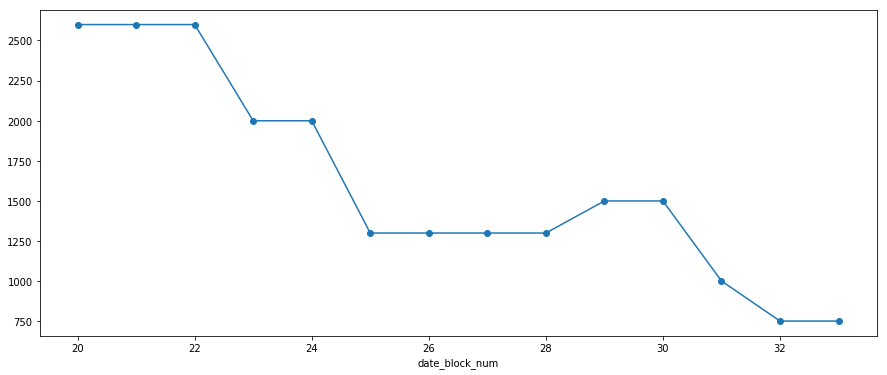

In [20]:
data['item_price_mean'].plot(marker='o')

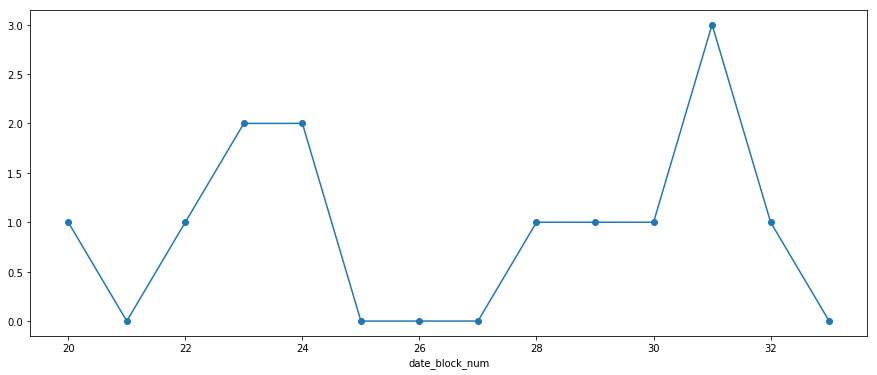

In [21]:
data['item_cnt_sum'].plot(marker='o')

array([<matplotlib.axes._subplots.AxesSubplot object at 0xa04b1d4c>,
      dtype=object)

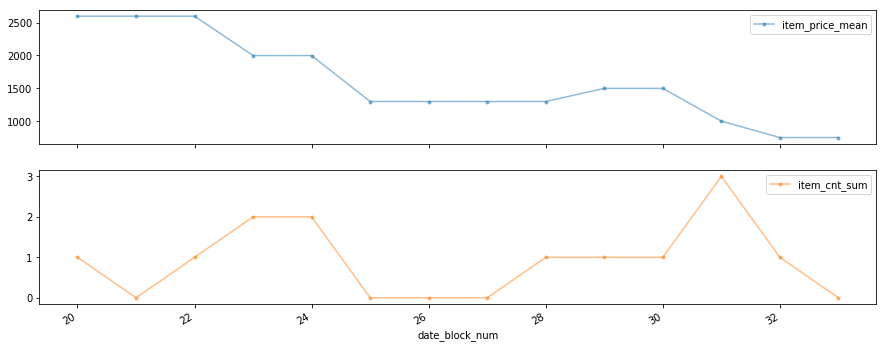

In [22]:
data.plot(marker='.', alpha=0.5, subplots=True)

In [16]:
df_dates = pd.read_csv(\
    input_prefix + '../date_blocks.csv',
    parse_dates=['last_date'],
    dtype={'date_block_num': np.int8},
    index_col=['date_block_num']
    )[['last_date']]
print('shape:', df_dates.shape)
df_dates.head()

shape: (35, 1)


,last_date
date_block_num,
0,2013-01-31
1,2013-02-28
2,2013-03-31
3,2013-04-30
4,2013-05-31


In [17]:
# ajustar dados de treino para o formato do Prophet
data2 = data[['item_cnt_sum']].merge(df_dates, left_index=True, right_index=True)
#data2 = data2.reset_index()
data2.columns = ['y', 'ds']
data2.head()

,y,ds
date_block_num,,
20,1,2014-09-30
21,0,2014-10-31
22,1,2014-11-30
23,2,2014-12-31
24,2,2015-01-31


In [23]:
data2

,y,ds
date_block_num,,
20,1,2014-09-30
21,0,2014-10-31
22,1,2014-11-30
23,2,2014-12-31
24,2,2015-01-31
25,0,2015-02-28
26,0,2015-03-31
27,0,2015-04-30
28,1,2015-05-31


In [24]:
# criar e treinar o modelo
model = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)
%time model.fit(data2)

INFO:fbprophet:n_changepoints greater than number of observations.Using 10.


CPU times: user 420 ms, sys: 8 ms, total: 428 ms
Wall time: 483 ms


In [40]:
# criar série com dados futuros
future = model.make_future_dataframe(periods=12, freq='M')
future.tail()

,ds
21,2016-06-30
22,2016-07-31
23,2016-08-31
24,2016-09-30
25,2016-10-31


In [41]:
future = pd.date_range(start='2015-11-30', periods=12, freq='M').to_frame()
future.columns = ['ds']
future

,ds
2015-11-30,2015-11-30
2015-12-31,2015-12-31
2016-01-31,2016-01-31
2016-02-29,2016-02-29
2016-03-31,2016-03-31
2016-04-30,2016-04-30
2016-05-31,2016-05-31
2016-06-30,2016-06-30
2016-07-31,2016-07-31
2016-08-31,2016-08-31


In [42]:
# realizar previsão com dados futuros
%time forecast = model.predict(future)
#forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast[['ds', 'yhat']].head()
#forecast.head()

CPU times: user 11.1 s, sys: 84 ms, total: 11.2 s
Wall time: 11.3 s


,ds,yhat
0,2015-11-30,1.0342
1,2015-12-31,1.0494
2,2016-01-31,1.0646
3,2016-02-29,1.0788
4,2016-03-31,1.0940


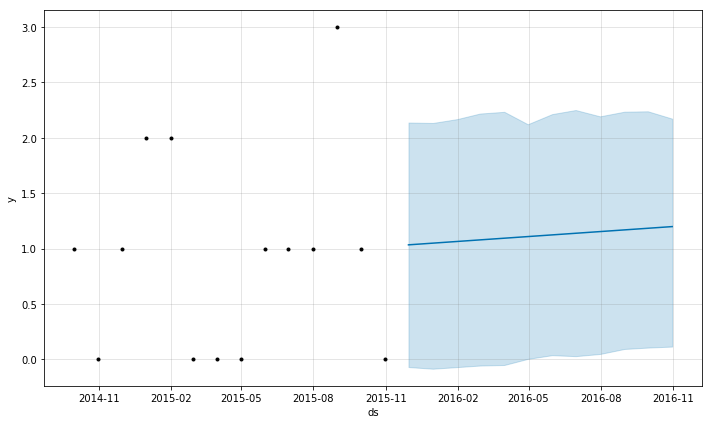

In [43]:
# plotar dados reais e previsão
fig1 = model.plot(forecast)

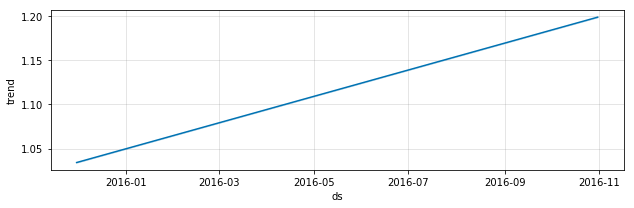

In [44]:
# decompor tendência e sazonalidades do modelo
fig2 = model.plot_components(forecast)

# definir períodos a serem considerados no modelo
periodo1 = 1.0
periodo2 = 365.25

# definir data inicial de corte
data_inicio_amostra = '2014-11'

print('Períodos sazonais: (%.2f, %.2f)' % (periodo1, periodo2))
print('Data de início da amostra:', data_inicio_amostra)

In [19]:
y = data['item_cnt_sum']

tamanho = len(y)
corte = int(np.ceil(tamanho * 0.75))
resto = tamanho - corte
print('Tamanho: %-3d\nCorte:   %-3d\nResto:    %-3d' % (tamanho, corte, resto))

y_train = y.iloc[:corte]
y_test = y.iloc[corte:]

Tamanho: 14 
Corte:   11 
Resto:    3  


In [20]:
y_train[:5]

date_block_num
20    1
21    0
22    1
23    2
24    2
Name: item_cnt_sum, dtype: int32

In [21]:
y_test[-5:]

date_block_num
31    3
32    1
33    0
Name: item_cnt_sum, dtype: int32

In [22]:
# Fit the model
estimator = TBATS(seasonal_periods=(12,), n_jobs=8)
%time model = estimator.fit(y_train)

CPU times: user 375 ms, sys: 75.6 ms, total: 451 ms
Wall time: 2.66 s


In [23]:
# Forecast 365 days ahead
y_forecast = model.forecast(steps=resto)
print(y_forecast)

y_forecast = y_forecast.round().astype(np.int32)
y_forecast

[ 3.00000000e+00  1.00000000e+00 -5.55111512e-16]


array([3, 1, 0], dtype=int32)

In [25]:
y_true = y[-resto:].values
y_true

array([3, 1, 0], dtype=int32)

In [26]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

print('MSE:', mean_squared_error(y_true, y_forecast))
print('MAE:', mean_absolute_error(y_true, y_forecast))
print('R²:', r2_score(y_true, y_forecast))

MSE: 0.0
MAE: 0.0
R²: 1.0


In [27]:
%time model = estimator.fit(y)

CPU times: user 442 ms, sys: 84 ms, total: 526 ms
Wall time: 2.44 s


In [28]:
y_pred = model.forecast(steps=3)
y_pred = y_pred.round().clip(0, 20).astype(np.int32)
y_pred

array([1, 2, 2], dtype=int32)

In [6]:
df_test = pd.read_csv(
    input_prefix + 'test.csv' + bzfile, #nrows=10000,
    dtype={'shop_id': np.int8, 'item_id': np.int16},
    index_col='ID')
print('shape:', df_test.shape)
df_test.head()

shape: (214200, 2)


,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [36]:
#!rm -f prediction.csv && touch prediction.csv

In [7]:
filename = 'prediction.csv'
last_id = None

with open(filename) as infile:
  empty = (infile.read(1) == '')
  if (not empty):
    last_line = list(infile)[-1]
    last_id = int(last_line.split(',')[0])
infile.close()

outfile = open(filename, "a+", buffering=100)
if (empty):
  outfile.write('ID,item_cnt_month\n')
  print('File does not exist. Creating one.')
else:
  print('File already exists. Resuming from ID #%d' % last_id)

#for i in range(0, 10):
#  outfile.write("%d,%.1f\n" % (i, i%7))
#outfile.close()

File already exists. Resuming from ID #124670


In [8]:
!tail prediction.csv

124661,0.0
124662,0.0
124663,0.0
124664,0.0
124665,0.0
124666,0.0
124667,0.0
124668,0.0
124669,0.0
124670,0.0


In [ ]:
estimator = TBATS(seasonal_periods=(12,), n_jobs=8)

for index, row in df_test.iterrows():
#for index, row in df_test.head(10).iterrows():
    if (last_id and index <= last_id):
      continue

    shop_id = row['shop_id']
    item_id = row['item_id']
    #print(index, shop_id, item_id)

    #df_sale = df_train.loc[shop_id, item_id][['item_cnt_sum']]
    df_sale = df_train.query('(shop_id == %d) & (item_id == %d)' % (shop_id, item_id))[['item_cnt_sum']]
    if (not df_sale.empty):

      df_sale = df_sale.reset_index().drop(columns=['shop_id', 'item_id']).set_index('date_block_num')
      df_sale = pd.merge(
        pd.DataFrame({'date_block_num': np.arange(df_sale.index.min(), 34)}).set_index('date_block_num'),
        df_sale, how='left', left_index=True, right_index=True)
      df_sale['item_cnt_sum'] = df_sale['item_cnt_sum'].fillna(0).astype(np.int32)
      #df_sale['item_price_mean'] = df_sale['item_price_mean'].fillna(
      #  method='bfill').fillna(method='ffill').astype(np.int32)

      if (df_sale.shape[0] >= 4):
          model = estimator.fit(df_sale['item_cnt_sum'])
          y_pred = model.forecast(steps=1)
          y_pred = y_pred[0].round().clip(0, 20)
          #y_pred = y_pred[0].round().clip(0, 20).astype(np.int32)
      else:
          y_pred = 0
    else:
      y_pred = 0
    
    outfile.write("%d,%.1f\n" % (index, y_pred))

    if (index % 10 == 0):
      outfile.flush()
      print(index, shop_id, item_id, y_pred)

outfile.close()

60990 25 16231 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61000 25 17015 0
61010 25 13133 0.0
61020 25 14222 1.0
61030 25 13812 1.0
61040 25 5010 0.0
61050 25 21210 0
61060 25 20916 4.0
61070 25 21664 0
61080 25 3232 0
61090 25 3547 1.0
61100 25 18707 0
61110 25 11674 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61120 25 16057 7.0
61130 25 15033 0
61140 25 10508 0.0
61150 25 7572 0
61160 25 6882 0.0
61170 25 14543 0
61180 25 19889 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61190 25 3280 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61200 22 5037 0.0
61210 22 4806 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61220 22 4717 0.0
61230 22 5666 6.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61240 22 5840 0
61250 22 5838 0
61260 22 3352 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61270 22 3604 0
61280 22 3443 5.0
61290 22 4365 0
61300 22 3733 0.0
61310 22 4052 0.0
61320 22 9395 0.0
61330 22 9469 0
61340 22 8653 0
61350 22 9001 1.0
61360 22 10447 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61370 22 10327 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61380 22 9927 0
61390 22 6506 0
61400 22 6731 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61410 22 6396 0.0
61420 22 6064 6.0
61430 22 7862 0
61440 22 7328 2.0
61450 22 7029 0
61460 22 15777 0.0
61470 22 16843 5.0
61480 22 15496 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61490 22 16103 5.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61500 22 18825 0.0
61510 22 19656 0
61520 22 18397 0
61530 22 15338 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61540 22 13023 0.0
61550 22 13415 0
61560 22 13464 0
61570 22 14832 0
61580 22 15069 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61590 22 15037 0
61600 22 2131 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61610 22 1732 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61620 22 2574 0.0
61630 22 3076 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61640 22 2779 1.0
61650 22 2873 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61660 22 20949 20.0
61670 22 21937 0
61680 22 20400 0
61690 22 20616 0
61700 22 1585 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61710 22 982 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61720 22 1486 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61730 22 2328 0
61740 22 2293 0.0
61750 22 3022 0
61760 22 2743 1.0
61770 22 1963 0
61780 22 1295 0
61790 22 22100 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61800 22 482 5.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61810 22 1877 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61820 22 1570 0.0
61830 22 4003 3.0
61840 22 3851 0.0
61850 22 4420 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61860 22 4085 6.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61870 22 3528 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61880 22 3459 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61890 22 12771 1.0
61900 22 13334 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61910 22 15047 0.0
61920 22 13818 0
61930 22 12549 0.0
61940 22 12698 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


61950 22 12360 5.0
61960 22 11811 1.0
61970 22 12023 0
61980 22 13275 0
61990 22 13303 0
62000 22 13226 0
62010 22 20609 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62020 22 19430 0.0
62030 22 21942 0
62040 22 18201 0
62050 22 16122 0.0
62060 22 14668 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62070 22 15323 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62080 22 17481 0.0
62090 22 16541 0.0
62100 22 1239 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62110 22 20631 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62120 22 2787 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62130 22 15282 0
62140 22 16145 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62150 22 19125 0
62160 22 17032 0
62170 22 5383 0
62180 22 4895 0.0
62190 22 6505 0
62200 22 6082 7.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62210 22 3822 3.0
62220 22 6129 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62230 22 3833 0.0
62240 22 3871 0.0
62250 22 13285 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62260 22 11938 0.0
62270 22 14457 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62280 22 7982 0.0
62290 22 7224 0
62300 22 10211 0.0
62310 22 9404 1.0
62320 22 4049 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62330 22 4999 0.0
62340 22 3342 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62350 22 10190 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62360 22 9408 0.0
62370 22 13237 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62380 22 10987 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62390 22 6625 1.0
62400 22 6090 0.0
62410 22 7019 0.0
62420 22 12500 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62430 22 10448 0
62440 22 12805 0.0
62450 22 14247 0
62460 22 7133 0
62470 22 10292 1.0
62480 22 1007 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62490 22 1717 0.0
62500 22 14390 0.0
62510 22 19908 0.0
62520 22 17888 0
62530 22 21722 0
62540 22 940 0
62550 22 18926 0.0
62560 22 17772 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62570 22 19219 0
62580 22 20225 0.0
62590 22 5816 1.0
62600 22 8868 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62610 22 17459 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62620 22 17420 0.0
62630 22 10812 0
62640 22 11771 0
62650 22 10554 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62660 22 10378 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62670 22 16125 0.0
62680 22 15300 1.0
62690 22 17270 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62700 22 16735 0.0
62710 22 13893 0
62720 22 13633 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62730 22 14267 0.0
62740 22 7592 0
62750 22 8734 0
62760 22 8986 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62770 22 8453 0
62780 22 4141 0
62790 22 6420 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62800 22 11266 0.0
62810 22 13270 0
62820 22 13100 3.0
62830 22 10146 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62840 22 10425 0
62850 22 11365 0
62860 22 14848 0
62870 22 21367 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62880 22 8077 0.0
62890 22 12286 0
62900 22 3028 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62910 22 3862 2.0
62920 22 794 0
62930 22 353 0
62940 22 1074 0
62950 22 13208 0
62960 22 12501 2.0
62970 22 10045 0
62980 22 12090 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


62990 22 11534 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63000 22 15512 0
63010 22 15166 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63020 22 16534 0.0
63030 22 16155 1.0
63040 22 12830 0.0
63050 22 14124 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63060 22 5945 0.0
63070 22 6678 0
63080 22 4944 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63090 22 5517 0
63100 22 8398 0
63110 22 7458 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63120 22 7882 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63130 22 7793 1.0
63140 22 3477 0
63150 22 8686 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63160 22 20560 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63170 22 19874 0
63180 22 17869 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63190 22 21548 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63200 22 18255 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63210 22 2639 0.0
63220 22 21827 0.0
63230 22 1238 0
63240 22 1247 0.0
63250 22 269 1.0
63260 22 687 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63270 22 93 0.0
63280 22 20718 0
63290 22 42 0.0
63300 22 21842 0.0
63310 22 2324 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63320 22 1663 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63330 22 3080 0
63340 22 2886 0
63350 22 13587 0
63360 22 13691 0
63370 22 15169 0
63380 22 14973 0
63390 22 13113 0
63400 22 11711 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63410 22 13231 0
63420 22 18677 2.0
63430 22 18686 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63440 22 20374 0.0
63450 22 20571 0
63460 22 19621 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63470 22 16036 0
63480 22 15276 0.0
63490 22 16177 0
63500 22 8687 0
63510 22 9171 0.0
63520 22 9366 0
63530 22 7459 0
63540 22 8148 0
63550 22 8510 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63560 22 9449 0.0
63570 22 10786 0.0
63580 22 10669 0.0
63590 22 11379 0.0
63600 22 11542 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63610 22 10893 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63620 22 9539 0.0
63630 22 10325 0.0
63640 22 9840 0
63650 22 10003 0.0
63660 22 4708 3.0
63670 22 4604 0.0
63680 22 5323 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63690 22 3897 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63700 22 3919 0
63710 22 3787 1.0
63720 22 4088 0
63730 22 6695 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63740 22 6378 1.0
63750 22 6857 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63760 22 5659 0.0
63770 22 3354 0
63780 22 1538 0
63790 22 22111 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63800 22 9019 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63810 22 11968 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63820 22 6027 0.0
63830 22 18361 0.0
63840 22 18629 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63850 22 17883 0
63860 22 18108 0
63870 22 19126 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63880 22 19488 0
63890 22 18759 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63900 22 18979 0
63910 22 3236 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


63920 22 19588 1.0
63930 22 20952 0
63940 22 21207 0
63950 22 20833 0
63960 22 20274 0.0
63970 22 21795 0
63980 22 21792 0.0
63990 22 19951 0
64000 22 19852 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


64010 22 20600 0
64020 22 20581 0
64030 22 6312 0
64040 22 3634 0
64050 22 4707 0
64060 22 8888 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


64070 22 10099 0
64080 22 6807 0
64090 22 8112 0.0
64100 22 19118 14.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


64110 22 21790 0.0
64120 22 13630 0
64130 22 15478 0
64140 22 15226 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


64150 22 2585 0.0
64160 22 2213 0
64170 22 1611 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


64180 22 12504 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


64190 22 13445 0
64200 22 11915 0.0
64210 22 20739 1.0
64220 22 21196 0
64230 22 14108 0.0
64240 22 3457 0
64250 22 3096 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


64260 22 15260 0.0
64270 22 17157 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


64280 22 413 0.0
64290 22 1010 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


64300 22 4364 0.0
64310 22 6528 0
64320 22 5470 0
64330 22 19337 1.0
64340 22 18017 0.0
64350 22 14892 1.0
64360 22 20393 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


64370 22 15171 0
64380 22 16093 0
64390 22 16111 0
64400 22 14962 0
64410 22 16207 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


64420 22 16786 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


64430 22 8157 0
64440 22 13448 0
64450 22 13224 0
64460 22 13512 0.0
64470 22 13288 0
64480 22 14164 0.0
64490 22 12808 0.0
64500 22 13647 0
64510 22 12332 0
64520 22 12091 0.0
64530 22 11268 0
64540 22 13223 0
64550 22 13221 0
64560 22 16179 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


64570 22 15524 0
64580 22 16045 0
64590 22 16910 0
64600 22 15667 0
64610 22 16243 0
64620 22 16349 0
64630 22 15015 0.0
64640 22 15134 0.0
64650 22 14987 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


64660 22 15318 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


64670 22 15168 0
64680 22 15220 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


64690 22 6870 0
64700 22 4480 0
64710 22 5063 0.0
64720 22 5155 0
64730 22 5187 0
64740 22 5121 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


64750 22 10069 0
64760 22 10287 0.0
64770 22 10180 0.0
64780 22 10772 0.0
64790 22 11363 0.0
64800 22 11044 0
64810 22 8459 0.0
64820 22 8363 0
64830 22 7580 0
64840 22 8968 0
64850 22 9338 0
64860 22 8428 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


64870 22 14361 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


64880 22 547 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


64890 22 12743 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


64900 22 20517 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


64910 22 7924 0.0
64920 22 3239 0.0
64930 22 15458 0.0
64940 22 18025 0
64950 22 15031 10.0
64960 22 14984 0
64970 22 1254 0
64980 22 18968 0
64990 22 21139 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


65000 22 3273 0
65010 22 13407 0
65020 22 21692 0
65030 22 19127 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


65040 22 16953 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


65050 22 21400 2.0
65060 22 20334 0
65070 22 13693 0
65080 22 12474 0
65090 22 8468 0
65100 22 11302 0
65110 22 448 0.0
65120 22 5272 0.0
65130 22 6028 0.0
65140 22 8855 0.0
65150 22 2540 0
65160 22 18315 0.0
65170 22 2191 0.0
65180 22 3333 0.0
65190 22 20879 0
65200 22 14760 0
65210 22 4637 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


65220 22 13494 1.0
65230 22 16032 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


65240 22 2523 0
65250 22 5540 0.0
65260 22 1453 1.0
65270 22 11011 0
65280 22 3548 0
65290 22 6307 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


65300 22 20196 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


65310 22 19751 0.0
65320 22 18457 0
65330 22 18208 0.0
65340 22 22013 0.0
65350 22 20653 0.0
65360 22 21053 0
65370 22 11516 0.0
65380 22 18481 0.0
65390 22 15222 0
65400 22 13327 0
65410 22 18031 0
65420 22 20821 0
65430 22 18939 1.0
65440 22 12208 0.0
65450 22 15654 0
65460 22 16028 0.0
65470 22 20516 0
65480 22 6400 0
65490 22 16166 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


65500 22 9534 0
65510 22 10581 0
65520 22 9111 0
65530 22 13099 0
65540 22 11874 0
65550 22 12192 0
65560 22 6430 0
65570 22 5761 0
65580 22 4903 0
65590 22 5382 0
65600 22 7817 0
65610 22 6959 0
65620 22 7057 0
65630 22 21978 0
65640 22 19347 0
65650 22 20012 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


65660 22 13732 0
65670 22 14934 0
65680 22 13341 0
65690 22 16396 0
65700 22 16813 0
65710 22 15988 0
65720 22 16272 0
65730 22 504 0
65740 22 688 0
65750 22 616 0
65760 22 204 0
65770 22 1394 0
65780 22 924 0
65790 22 1506 0
65800 22 849 0
65810 22 20361 1.0
65820 22 3715 0
65830 22 3411 0
65840 22 4765 0
65850 22 4260 0
65860 22 4144 0
65870 22 4203 0
65880 22 1794 0
65890 22 2338 0
65900 22 1792 0
65910 22 2856 0
65920 22 2434 0
65930 22 3136 0
65940 22 1018 0.0
65950 22 19258 0.0
65960 22 4736 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


65970 22 5363 0.0
65980 22 17390 1.0
65990 22 11682 0.0
66000 22 15735 0
66010 22 14899 0.0
66020 22 20212 0.0
66030 22 5899 0.0
66040 22 18476 0.0
66050 22 6835 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66060 22 15405 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66070 22 17756 0.0
66080 22 18500 1.0
66090 22 16231 0
66100 22 17015 0.0
66110 22 13133 0.0
66120 22 14222 0.0
66130 22 13812 0.0
66140 22 5010 2.0
66150 22 21210 0
66160 22 20916 0
66170 22 21664 0
66180 22 3232 0
66190 22 3547 0
66200 22 18707 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66210 22 11674 0
66220 22 16057 0.0
66230 22 15033 0
66240 22 10508 0
66250 22 7572 0
66260 22 6882 0
66270 22 14543 0
66280 22 19889 0
66290 22 3280 0.0
66300 24 5037 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66310 24 4806 10.0
66320 24 4717 0.0
66330 24 5666 3.0
66340 24 5840 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66350 24 5838 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66360 24 3352 0
66370 24 3604 0
66380 24 3443 0.0
66390 24 4365 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66400 24 3733 4.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66410 24 4052 5.0
66420 24 9395 0
66430 24 9469 0
66440 24 8653 0.0
66450 24 9001 0.0
66460 24 10447 0
66470 24 10327 0
66480 24 9927 0
66490 24 6506 0
66500 24 6731 0
66510 24 6396 0
66520 24 6064 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66530 24 7862 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66540 24 7328 0.0
66550 24 7029 0
66560 24 15777 0.0
66570 24 16843 0
66580 24 15496 0
66590 24 16103 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66600 24 18825 0.0
66610 24 19656 0
66620 24 18397 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66630 24 15338 0
66640 24 13023 1.0
66650 24 13415 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66660 24 13464 4.0
66670 24 14832 0
66680 24 15069 0
66690 24 15037 0
66700 24 2131 0
66710 24 1732 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66720 24 2574 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66730 24 3076 2.0
66740 24 2779 0.0
66750 24 2873 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66760 24 20949 20.0
66770 24 21937 0
66780 24 20400 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66790 24 20616 0.0
66800 24 1585 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66810 24 982 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66820 24 1486 2.0
66830 24 2328 0
66840 24 2293 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66850 24 3022 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66860 24 2743 0.0
66870 24 1963 0
66880 24 1295 0
66890 24 22100 1.0
66900 24 482 5.0
66910 24 1877 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66920 24 1570 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66930 24 4003 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66940 24 3851 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66950 24 4420 0.0
66960 24 4085 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


66970 24 3528 1.0
66980 24 3459 0
66990 24 12771 0.0
67000 24 13334 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67010 24 15047 0
67020 24 13818 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67030 24 12549 0.0
67040 24 12698 0
67050 24 12360 0.0
67060 24 11811 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67070 24 12023 0
67080 24 13275 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67090 24 13303 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67100 24 13226 0
67110 24 20609 0.0
67120 24 19430 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67130 24 21942 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67140 24 18201 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67150 24 16122 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67160 24 14668 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67170 24 15323 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67180 24 17481 0.0
67190 24 16541 0.0
67200 24 1239 4.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67210 24 20631 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67220 24 2787 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67230 24 15282 2.0
67240 24 16145 0
67250 24 19125 0
67260 24 17032 0
67270 24 5383 0
67280 24 4895 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67290 24 6505 0
67300 24 6082 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67310 24 3822 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67320 24 6129 0
67330 24 3833 2.0
67340 24 3871 0.0
67350 24 13285 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67360 24 11938 0.0
67370 24 14457 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67380 24 7982 4.0
67390 24 7224 0
67400 24 10211 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67410 24 9404 2.0
67420 24 4049 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67430 24 4999 0
67440 24 3342 0.0
67450 24 10190 0
67460 24 9408 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67470 24 13237 0
67480 24 10987 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67490 24 6625 0.0
67500 24 6090 1.0
67510 24 7019 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67520 24 12500 0.0
67530 24 10448 0
67540 24 12805 0.0
67550 24 14247 0.0
67560 24 7133 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67570 24 10292 0.0
67580 24 1007 0.0
67590 24 1717 1.0
67600 24 14390 0.0
67610 24 19908 2.0
67620 24 17888 0
67630 24 21722 0
67640 24 940 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67650 24 18926 0
67660 24 17772 0
67670 24 19219 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67680 24 20225 0.0
67690 24 5816 0.0
67700 24 8868 0
67710 24 17459 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67720 24 17420 0.0
67730 24 10812 0
67740 24 11771 0
67750 24 10554 0
67760 24 10378 1.0
67770 24 16125 0
67780 24 15300 0.0
67790 24 17270 0.0
67800 24 16735 0.0
67810 24 13893 0.0
67820 24 13633 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67830 24 14267 0.0
67840 24 7592 0
67850 24 8734 2.0
67860 24 8986 0.0
67870 24 8453 0
67880 24 4141 0
67890 24 6420 0
67900 24 11266 0
67910 24 13270 0
67920 24 13100 0.0
67930 24 10146 0
67940 24 10425 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67950 24 11365 0
67960 24 14848 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


67970 24 21367 1.0
67980 24 8077 0.0
67990 24 12286 1.0
68000 24 3028 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


68010 24 3862 0.0
68020 24 794 0
68030 24 353 0
68040 24 1074 0
68050 24 13208 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


68060 24 12501 0.0
68070 24 10045 0
68080 24 12090 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


68090 24 11534 0
68100 24 15512 0
68110 24 15166 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


68120 24 16534 0.0
68130 24 16155 0
68140 24 12830 1.0
68150 24 14124 0.0
68160 24 5945 0.0
68170 24 6678 0
68180 24 4944 1.0
68190 24 5517 0
68200 24 8398 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


68210 24 7458 3.0
68220 24 7882 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


68230 24 7793 1.0
68240 24 3477 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


68250 24 8686 0.0
68260 24 20560 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


68270 24 19874 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


68280 24 17869 0.0
68290 24 21548 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


68300 24 18255 0.0
68310 24 2639 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


68320 24 21827 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


68330 24 1238 0
68340 24 1247 0.0
68350 24 269 0
68360 24 687 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


68370 24 93 0.0
68380 24 20718 0
68390 24 42 0.0
68400 24 21842 0.0
68410 24 2324 0
68420 24 1663 0
68430 24 3080 0
68440 24 2886 0
68450 24 13587 0
68460 24 13691 0
68470 24 15169 0
68480 24 14973 0
68490 24 13113 0
68500 24 11711 0.0
68510 24 13231 0
68520 24 18677 0.0
68530 24 18686 0
68540 24 20374 0
68550 24 20571 0
68560 24 19621 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


68570 24 16036 0
68580 24 15276 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


68590 24 16177 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


68600 24 8687 0.0
68610 24 9171 0.0
68620 24 9366 0
68630 24 7459 0.0
68640 24 8148 0
68650 24 8510 0
68660 24 9449 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


68670 24 10786 0.0
68680 24 10669 0
68690 24 11379 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


68700 24 11542 0
68710 24 10893 0
68720 24 9539 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


68730 24 10325 0.0
68740 24 9840 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


68750 24 10003 0
68760 24 4708 0
68770 24 4604 2.0
68780 24 5323 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


68790 24 3897 0.0
68800 24 3919 0
68810 24 3787 0.0
68820 24 4088 0
68830 24 6695 1.0
68840 24 6378 0.0
68850 24 6857 1.0
68860 24 5659 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


68870 24 3354 0
68880 24 1538 0
68890 24 22111 0.0
68900 24 9019 0.0
68910 24 11968 1.0
68920 24 6027 1.0
68930 24 18361 0.0
68940 24 18629 0
68950 24 17883 0
68960 24 18108 0
68970 24 19126 0.0
68980 24 19488 0
68990 24 18759 0
69000 24 18979 0
69010 24 3236 0.0
69020 24 19588 0.0
69030 24 20952 0
69040 24 21207 0
69050 24 20833 0
69060 24 20274 0
69070 24 21795 0
69080 24 21792 0
69090 24 19951 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


69100 24 19852 0
69110 24 20600 0
69120 24 20581 0
69130 24 6312 0
69140 24 3634 0.0
69150 24 4707 0
69160 24 8888 0.0
69170 24 10099 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


69180 24 6807 0
69190 24 8112 0
69200 24 19118 12.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


69210 24 21790 0
69220 24 13630 0
69230 24 15478 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


69240 24 15226 0.0
69250 24 2585 0
69260 24 2213 0
69270 24 1611 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


69280 24 12504 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


69290 24 13445 0
69300 24 11915 0.0
69310 24 20739 0.0
69320 24 21196 0
69330 24 14108 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


69340 24 3457 1.0
69350 24 3096 0
69360 24 15260 0
69370 24 17157 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


69380 24 413 0
69390 24 1010 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


69400 24 4364 0
69410 24 6528 0
69420 24 5470 0.0
69430 24 19337 0
69440 24 18017 0.0
69450 24 14892 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


69460 24 20393 1.0
69470 24 15171 0
69480 24 16093 0
69490 24 16111 1.0
69500 24 14962 0
69510 24 16207 0.0
69520 24 16786 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


69530 24 8157 0.0
69540 24 13448 0
69550 24 13224 0
69560 24 13512 0.0
69570 24 13288 0
69580 24 14164 0.0
69590 24 12808 0.0
69600 24 13647 0
69610 24 12332 0
69620 24 12091 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


69630 24 11268 1.0
69640 24 13223 0
69650 24 13221 0
69660 24 16179 0
69670 24 15524 0.0
69680 24 16045 0
69690 24 16910 0
69700 24 15667 0
69710 24 16243 0
69720 24 16349 0
69730 24 15015 0.0
69740 24 15134 0
69750 24 14987 0
69760 24 15318 0
69770 24 15168 0
69780 24 15220 0
69790 24 6870 0
69800 24 4480 0.0
69810 24 5063 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


69820 24 5155 0
69830 24 5187 0
69840 24 5121 0
69850 24 10069 0
69860 24 10287 0
69870 24 10180 0.0
69880 24 10772 0.0
69890 24 11363 0.0
69900 24 11044 0.0
69910 24 8459 0.0
69920 24 8363 0.0
69930 24 7580 0
69940 24 8968 0
69950 24 9338 0
69960 24 8428 0
69970 24 14361 0
69980 24 547 0
69990 24 12743 0.0
70000 24 20517 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


70010 24 7924 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


70020 24 3239 1.0
70030 24 15458 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


70040 24 18025 0
70050 24 15031 0.0
70060 24 14984 0
70070 24 1254 0
70080 24 18968 0
70090 24 21139 0
70100 24 3273 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


70110 24 13407 0
70120 24 21692 0
70130 24 19127 0.0
70140 24 16953 0.0
70150 24 21400 0
70160 24 20334 0
70170 24 13693 0
70180 24 12474 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


70190 24 8468 0
70200 24 11302 0
70210 24 448 0.0
70220 24 5272 6.0
70230 24 6028 0
70240 24 8855 0.0
70250 24 2540 0
70260 24 18315 0.0
70270 24 2191 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


70280 24 3333 0.0
70290 24 20879 0
70300 24 14760 0
70310 24 4637 0.0
70320 24 13494 1.0
70330 24 16032 5.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


70340 24 2523 0.0
70350 24 5540 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


70360 24 1453 0.0
70370 24 11011 0
70380 24 3548 1.0
70390 24 6307 0
70400 24 20196 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


70410 24 19751 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


70420 24 18457 0
70430 24 18208 0.0
70440 24 22013 0
70450 24 20653 0.0
70460 24 21053 0
70470 24 11516 0
70480 24 18481 0.0
70490 24 15222 0
70500 24 13327 0
70510 24 18031 0
70520 24 20821 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


70530 24 18939 0
70540 24 12208 0.0
70550 24 15654 0.0
70560 24 16028 0.0
70570 24 20516 0
70580 24 6400 1.0
70590 24 16166 0
70600 24 9534 0
70610 24 10581 0
70620 24 9111 0
70630 24 13099 0
70640 24 11874 0
70650 24 12192 0
70660 24 6430 0
70670 24 5761 0
70680 24 4903 0
70690 24 5382 0
70700 24 7817 0
70710 24 6959 0
70720 24 7057 0
70730 24 21978 0
70740 24 19347 0
70750 24 20012 0
70760 24 13732 0
70770 24 14934 0
70780 24 13341 0
70790 24 16396 0
70800 24 16813 0
70810 24 15988 0
70820 24 16272 0
70830 24 504 0
70840 24 688 0
70850 24 616 0
70860 24 204 0
70870 24 1394 0
70880 24 924 0
70890 24 1506 0
70900 24 849 0
70910 24 20361 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


70920 24 3715 0
70930 24 3411 0
70940 24 4765 0
70950 24 4260 0
70960 24 4144 0
70970 24 4203 0
70980 24 1794 0
70990 24 2338 0
71000 24 1792 0
71010 24 2856 0
71020 24 2434 0
71030 24 3136 0
71040 24 1018 0.0
71050 24 19258 0.0
71060 24 4736 0
71070 24 5363 0.0
71080 24 17390 0
71090 24 11682 0
71100 24 15735 0
71110 24 14899 3.0
71120 24 20212 0
71130 24 5899 0.0
71140 24 18476 1.0
71150 24 6835 0.0
71160 24 15405 0
71170 24 17756 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


71180 24 18500 0
71190 24 16231 0
71200 24 17015 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


71210 24 13133 0.0
71220 24 14222 0.0
71230 24 13812 0.0
71240 24 5010 1.0
71250 24 21210 0
71260 24 20916 0
71270 24 21664 0
71280 24 3232 0
71290 24 3547 0.0
71300 24 18707 0
71310 24 11674 0
71320 24 16057 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


71330 24 15033 0
71340 24 10508 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


71350 24 7572 0
71360 24 6882 0.0
71370 24 14543 0
71380 24 19889 0
71390 24 3280 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


71400 21 5037 4.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


71410 21 4806 2.0
71420 21 4717 2.0
71430 21 5666 20.0
71440 21 5840 0
71450 21 5838 9.0
71460 21 3352 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


71470 21 3604 0
71480 21 3443 2.0
71490 21 4365 0.0
71500 21 3733 0.0
71510 21 4052 1.0
71520 21 9395 0.0
71530 21 9469 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


71540 21 8653 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


71550 21 9001 0.0
71560 21 10447 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


71570 21 10327 0.0
71580 21 9927 0
71590 21 6506 0
71600 21 6731 0
71610 21 6396 0.0
71620 21 6064 1.0
71630 21 7862 0
71640 21 7328 0
71650 21 7029 0
71660 21 15777 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


71670 21 16843 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


71680 21 15496 0.0
71690 21 16103 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


71700 21 18825 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


71710 21 19656 0
71720 21 18397 0
71730 21 15338 0
71740 21 13023 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


71750 21 13415 0
71760 21 13464 0
71770 21 14832 0
71780 21 15069 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


71790 21 15037 0
71800 21 2131 0
71810 21 1732 0
71820 21 2574 2.0
71830 21 3076 1.0
71840 21 2779 0.0
71850 21 2873 0.0
71860 21 20949 20.0
71870 21 21937 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


71880 21 20400 0
71890 21 20616 2.0
71900 21 1585 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


71910 21 982 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


71920 21 1486 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


71930 21 2328 0
71940 21 2293 0.0
71950 21 3022 0
71960 21 2743 0.0
71970 21 1963 0
71980 21 1295 0
71990 21 22100 16.0
72000 21 482 1.0
72010 21 1877 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


72020 21 1570 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


72030 21 4003 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


72040 21 3851 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


72050 21 4420 0.0
72060 21 4085 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


72070 21 3528 0.0
72080 21 3459 0
72090 21 12771 0.0
72100 21 13334 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


72110 21 15047 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


72120 21 13818 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


72130 21 12549 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


72140 21 12698 0
72150 21 12360 0.0
72160 21 11811 1.0
72170 21 12023 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


72180 21 13275 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


72190 21 13303 0
72200 21 13226 0
72210 21 20609 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


72220 21 19430 1.0
72230 21 21942 0
72240 21 18201 0.0
72250 21 16122 0.0
72260 21 14668 0.0
72270 21 15323 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


72280 21 17481 1.0
72290 21 16541 0.0
72300 21 1239 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


72310 21 20631 0.0
72320 21 2787 0
72330 21 15282 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


72340 21 16145 0
72350 21 19125 0
72360 21 17032 0
72370 21 5383 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


72380 21 4895 0.0
72390 21 6505 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


72400 21 6082 1.0
72410 21 3822 1.0
72420 21 6129 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


72430 21 3833 1.0
72440 21 3871 0.0
72450 21 13285 6.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


72460 21 11938 1.0
72470 21 14457 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


72480 21 7982 4.0
72490 21 7224 0
72500 21 10211 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


72510 21 9404 1.0
72520 21 4049 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


72530 21 4999 0
72540 21 3342 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


72550 21 10190 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


72560 21 9408 2.0
72570 21 13237 0
72580 21 10987 0.0
72590 21 6625 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


72600 21 6090 1.0
72610 21 7019 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


72620 21 12500 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


72630 21 10448 0
72640 21 12805 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


72650 21 14247 0.0
72660 21 7133 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


72670 21 10292 0.0
72680 21 1007 1.0
72690 21 1717 0.0
72700 21 14390 0.0
72710 21 19908 0.0
72720 21 17888 0
72730 21 21722 0
72740 21 940 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


72750 21 18926 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


72760 21 17772 0
72770 21 19219 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


72780 21 20225 1.0
72790 21 5816 0.0
72800 21 8868 0
72810 21 17459 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


72820 21 17420 0.0
72830 21 10812 0
72840 21 11771 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


72850 21 10554 0
72860 21 10378 1.0
72870 21 16125 0.0
72880 21 15300 1.0
72890 21 17270 4.0
72900 21 16735 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


72910 21 13893 0.0
72920 21 13633 0
72930 21 14267 2.0
72940 21 7592 0
72950 21 8734 0.0
72960 21 8986 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


72970 21 8453 0
72980 21 4141 0
72990 21 6420 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


73000 21 11266 0.0
73010 21 13270 0
73020 21 13100 0.0
73030 21 10146 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


73040 21 10425 0
73050 21 11365 0
73060 21 14848 0
73070 21 21367 1.0
73080 21 8077 0.0
73090 21 12286 0.0
73100 21 3028 0.0
73110 21 3862 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


73120 21 794 0
73130 21 353 0
73140 21 1074 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


73150 21 13208 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


73160 21 12501 0.0
73170 21 10045 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


73180 21 12090 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


73190 21 11534 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


73200 21 15512 0
73210 21 15166 0
73220 21 16534 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


73230 21 16155 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


73240 21 12830 0.0
73250 21 14124 2.0
73260 21 5945 0.0
73270 21 6678 0
73280 21 4944 0
73290 21 5517 0
73300 21 8398 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


73310 21 7458 1.0
73320 21 7882 0.0
73330 21 7793 7.0
73340 21 3477 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


73350 21 8686 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


73360 21 20560 0
73370 21 19874 0
73380 21 17869 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


73390 21 21548 0
73400 21 18255 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


73410 21 2639 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


73420 21 21827 0
73430 21 1238 0
73440 21 1247 1.0
73450 21 269 0
73460 21 687 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


73470 21 93 0.0
73480 21 20718 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


73490 21 42 0.0
73500 21 21842 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


73510 21 2324 0
73520 21 1663 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


73530 21 3080 0
73540 21 2886 1.0
73550 21 13587 0
73560 21 13691 0
73570 21 15169 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


73580 21 14973 0
73590 21 13113 0
73600 21 11711 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


73610 21 13231 0
73620 21 18677 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


73630 21 18686 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


73640 21 20374 0.0
73650 21 20571 0
73660 21 19621 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


73670 21 16036 9.0
73680 21 15276 0.0
73690 21 16177 1.0
73700 21 8687 0.0
73710 21 9171 0.0
73720 21 9366 0
73730 21 7459 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


73740 21 8148 0
73750 21 8510 0.0
73760 21 9449 0.0
73770 21 10786 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


73780 21 10669 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


73790 21 11379 0.0
73800 21 11542 0
73810 21 10893 0
73820 21 9539 0.0
73830 21 10325 1.0
73840 21 9840 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


73850 21 10003 0.0
73860 21 4708 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


73870 21 4604 0.0
73880 21 5323 3.0
73890 21 3897 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


73900 21 3919 0
73910 21 3787 3.0
73920 21 4088 0
73930 21 6695 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


73940 21 6378 0.0
73950 21 6857 0.0
73960 21 5659 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


73970 21 3354 0
73980 21 1538 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


73990 21 22111 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


74000 21 9019 0.0
74010 21 11968 1.0
74020 21 6027 0.0
74030 21 18361 0.0
74040 21 18629 0
74050 21 17883 0.0
74060 21 18108 0
74070 21 19126 0.0
74080 21 19488 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


74090 21 18759 0
74100 21 18979 0
74110 21 3236 0.0
74120 21 19588 0.0
74130 21 20952 0
74140 21 21207 0
74150 21 20833 0
74160 21 20274 0.0
74170 21 21795 0.0
74180 21 21792 0.0
74190 21 19951 0.0
74200 21 19852 0
74210 21 20600 0
74220 21 20581 0.0
74230 21 6312 0.0
74240 21 3634 0.0
74250 21 4707 0
74260 21 8888 0.0
74270 21 10099 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


74280 21 6807 0
74290 21 8112 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


74300 21 19118 20.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


74310 21 21790 0
74320 21 13630 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


74330 21 15478 0.0
74340 21 15226 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


74350 21 2585 0
74360 21 2213 0
74370 21 1611 0.0
74380 21 12504 0.0
74390 21 13445 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


74400 21 11915 0.0
74410 21 20739 0.0
74420 21 21196 0
74430 21 14108 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


74440 21 3457 0
74450 21 3096 0
74460 21 15260 2.0
74470 21 17157 0.0
74480 21 413 5.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


74490 21 1010 0.0
74500 21 4364 0.0
74510 21 6528 0
74520 21 5470 0.0
74530 21 19337 0.0
74540 21 18017 0.0
74550 21 14892 0.0
74560 21 20393 2.0
74570 21 15171 1.0
74580 21 16093 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


74590 21 16111 0.0
74600 21 14962 0
74610 21 16207 0.0
74620 21 16786 0.0
74630 21 8157 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


74640 21 13448 0
74650 21 13224 0
74660 21 13512 0.0
74670 21 13288 0
74680 21 14164 0.0
74690 21 12808 0.0
74700 21 13647 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


74710 21 12332 0
74720 21 12091 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


74730 21 11268 0.0
74740 21 13223 0
74750 21 13221 0
74760 21 16179 0
74770 21 15524 0.0
74780 21 16045 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


74790 21 16910 0
74800 21 15667 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


74810 21 16243 0
74820 21 16349 0
74830 21 15015 0.0
74840 21 15134 1.0
74850 21 14987 0
74860 21 15318 0
74870 21 15168 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


74880 21 15220 1.0
74890 21 6870 0
74900 21 4480 0.0
74910 21 5063 0
74920 21 5155 0
74930 21 5187 0
74940 21 5121 0
74950 21 10069 0
74960 21 10287 0.0
74970 21 10180 0.0
74980 21 10772 0.0
74990 21 11363 0.0
75000 21 11044 0.0
75010 21 8459 0.0
75020 21 8363 1.0
75030 21 7580 0
75040 21 8968 0
75050 21 9338 0
75060 21 8428 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


75070 21 14361 0.0
75080 21 547 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


75090 21 12743 0.0
75100 21 20517 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


75110 21 7924 0.0
75120 21 3239 0.0
75130 21 15458 1.0
75140 21 18025 1.0
75150 21 15031 0.0
75160 21 14984 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


75170 21 1254 0
75180 21 18968 0.0
75190 21 21139 0
75200 21 3273 0
75210 21 13407 2.0
75220 21 21692 0
75230 21 19127 0.0
75240 21 16953 0.0
75250 21 21400 0.0
75260 21 20334 0
75270 21 13693 0
75280 21 12474 0
75290 21 8468 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


75300 21 11302 0
75310 21 448 0.0
75320 21 5272 0.0
75330 21 6028 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


75340 21 8855 0.0
75350 21 2540 0
75360 21 18315 0.0
75370 21 2191 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


75380 21 3333 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


75390 21 20879 0
75400 21 14760 0
75410 21 4637 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


75420 21 13494 0.0
75430 21 16032 2.0
75440 21 2523 0.0
75450 21 5540 0
75460 21 1453 0.0
75470 21 11011 0.0
75480 21 3548 0
75490 21 6307 1.0
75500 21 20196 0
75510 21 19751 0.0
75520 21 18457 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


75530 21 18208 0.0
75540 21 22013 1.0
75550 21 20653 0
75560 21 21053 0
75570 21 11516 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


75580 21 18481 0.0
75590 21 15222 0
75600 21 13327 0
75610 21 18031 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


75620 21 20821 0
75630 21 18939 0
75640 21 12208 0.0
75650 21 15654 0.0
75660 21 16028 0.0
75670 21 20516 0.0
75680 21 6400 0.0
75690 21 16166 0
75700 21 9534 0
75710 21 10581 0
75720 21 9111 0
75730 21 13099 0
75740 21 11874 0
75750 21 12192 0
75760 21 6430 0
75770 21 5761 0
75780 21 4903 0
75790 21 5382 0
75800 21 7817 0
75810 21 6959 0
75820 21 7057 0
75830 21 21978 0
75840 21 19347 0
75850 21 20012 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


75860 21 13732 0
75870 21 14934 0
75880 21 13341 0
75890 21 16396 0
75900 21 16813 0
75910 21 15988 0
75920 21 16272 0
75930 21 504 0
75940 21 688 0
75950 21 616 0
75960 21 204 0
75970 21 1394 0
75980 21 924 0
75990 21 1506 0
76000 21 849 0
76010 21 20361 0.0
76020 21 3715 0
76030 21 3411 0
76040 21 4765 0
76050 21 4260 0
76060 21 4144 0
76070 21 4203 0
76080 21 1794 0
76090 21 2338 0
76100 21 1792 0
76110 21 2856 0
76120 21 2434 0
76130 21 3136 0
76140 21 1018 0.0
76150 21 19258 0.0
76160 21 4736 0.0
76170 21 5363 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


76180 21 17390 0
76190 21 11682 0
76200 21 15735 0
76210 21 14899 0.0
76220 21 20212 0
76230 21 5899 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


76240 21 18476 0.0
76250 21 6835 1.0
76260 21 15405 0.0
76270 21 17756 0.0
76280 21 18500 0.0
76290 21 16231 0
76300 21 17015 1.0
76310 21 13133 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


76320 21 14222 0.0
76330 21 13812 0.0
76340 21 5010 1.0
76350 21 21210 0
76360 21 20916 0
76370 21 21664 0
76380 21 3232 0
76390 21 3547 0.0
76400 21 18707 0
76410 21 11674 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


76420 21 16057 0.0
76430 21 15033 0
76440 21 10508 0.0
76450 21 7572 0
76460 21 6882 0.0
76470 21 14543 0.0
76480 21 19889 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


76490 21 3280 0.0
76500 15 5037 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


76510 15 4806 5.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


76520 15 4717 1.0
76530 15 5666 16.0
76540 15 5840 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


76550 15 5838 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


76560 15 3352 0
76570 15 3604 0
76580 15 3443 0.0
76590 15 4365 2.0
76600 15 3733 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


76610 15 4052 0.0
76620 15 9395 1.0
76630 15 9469 0
76640 15 8653 0.0
76650 15 9001 0.0
76660 15 10447 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


76670 15 10327 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


76680 15 9927 0
76690 15 6506 0
76700 15 6731 0
76710 15 6396 0.0
76720 15 6064 5.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


76730 15 7862 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


76740 15 7328 3.0
76750 15 7029 0
76760 15 15777 0.0
76770 15 16843 0
76780 15 15496 0.0
76790 15 16103 0
76800 15 18825 0.0
76810 15 19656 0
76820 15 18397 0
76830 15 15338 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


76840 15 13023 5.0
76850 15 13415 0
76860 15 13464 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


76870 15 14832 0
76880 15 15069 0
76890 15 15037 0
76900 15 2131 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


76910 15 1732 0
76920 15 2574 1.0
76930 15 3076 0.0
76940 15 2779 0.0
76950 15 2873 2.0
76960 15 20949 20.0
76970 15 21937 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


76980 15 20400 0
76990 15 20616 1.0
77000 15 1585 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


77010 15 982 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


77020 15 1486 10.0
77030 15 2328 0
77040 15 2293 0.0
77050 15 3022 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


77060 15 2743 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


77070 15 1963 0
77080 15 1295 0
77090 15 22100 0.0
77100 15 482 1.0
77110 15 1877 0.0
77120 15 1570 7.0
77130 15 4003 0.0
77140 15 3851 0.0
77150 15 4420 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


77160 15 4085 9.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


77170 15 3528 0.0
77180 15 3459 0
77190 15 12771 0.0
77200 15 13334 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


77210 15 15047 0
77220 15 13818 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


77230 15 12549 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


77240 15 12698 0
77250 15 12360 0.0
77260 15 11811 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


77270 15 12023 0
77280 15 13275 0
77290 15 13303 0
77300 15 13226 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


77310 15 20609 3.0
77320 15 19430 1.0
77330 15 21942 0
77340 15 18201 0.0
77350 15 16122 0
77360 15 14668 0.0
77370 15 15323 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


77380 15 17481 1.0
77390 15 16541 0.0
77400 15 1239 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


77410 15 20631 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


77420 15 2787 0
77430 15 15282 2.0
77440 15 16145 0
77450 15 19125 0
77460 15 17032 0
77470 15 5383 0
77480 15 4895 6.0
77490 15 6505 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


77500 15 6082 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


77510 15 3822 0
77520 15 6129 0
77530 15 3833 0.0
77540 15 3871 0.0
77550 15 13285 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


77560 15 11938 0.0
77570 15 14457 1.0
77580 15 7982 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


77590 15 7224 0
77600 15 10211 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


77610 15 9404 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


77620 15 4049 0.0
77630 15 4999 0.0
77640 15 3342 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


77650 15 10190 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


77660 15 9408 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


77670 15 13237 0
77680 15 10987 0.0
77690 15 6625 0.0
77700 15 6090 1.0
77710 15 7019 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


77720 15 12500 2.0
77730 15 10448 0
77740 15 12805 0.0
77750 15 14247 0.0
77760 15 7133 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


77770 15 10292 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


77780 15 1007 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


77790 15 1717 1.0
77800 15 14390 1.0
77810 15 19908 0.0
77820 15 17888 0
77830 15 21722 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


77840 15 940 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


77850 15 18926 0
77860 15 17772 0
77870 15 19219 0
77880 15 20225 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


77890 15 5816 1.0
77900 15 8868 0
77910 15 17459 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


77920 15 17420 0.0
77930 15 10812 0
77940 15 11771 0
77950 15 10554 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


77960 15 10378 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


77970 15 16125 0.0
77980 15 15300 0.0
77990 15 17270 0.0
78000 15 16735 0.0
78010 15 13893 0.0
78020 15 13633 0
78030 15 14267 0.0
78040 15 7592 0
78050 15 8734 0
78060 15 8986 0.0
78070 15 8453 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


78080 15 4141 0
78090 15 6420 0
78100 15 11266 0
78110 15 13270 0
78120 15 13100 0
78130 15 10146 0
78140 15 10425 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


78150 15 11365 0
78160 15 14848 0
78170 15 21367 0.0
78180 15 8077 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


78190 15 12286 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


78200 15 3028 2.0
78210 15 3862 0.0
78220 15 794 0
78230 15 353 0
78240 15 1074 0.0
78250 15 13208 0
78260 15 12501 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


78270 15 10045 0
78280 15 12090 0.0
78290 15 11534 0
78300 15 15512 0
78310 15 15166 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


78320 15 16534 0.0
78330 15 16155 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


78340 15 12830 0.0
78350 15 14124 0
78360 15 5945 0.0
78370 15 6678 0
78380 15 4944 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


78390 15 5517 0
78400 15 8398 0
78410 15 7458 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


78420 15 7882 0.0
78430 15 7793 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


78440 15 3477 1.0
78450 15 8686 0.0
78460 15 20560 0
78470 15 19874 0
78480 15 17869 1.0
78490 15 21548 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


78500 15 18255 0.0
78510 15 2639 0.0
78520 15 21827 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


78530 15 1238 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


78540 15 1247 0.0
78550 15 269 0
78560 15 687 0.0
78570 15 93 0
78580 15 20718 0
78590 15 42 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


78600 15 21842 0.0
78610 15 2324 0
78620 15 1663 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


78630 15 3080 0
78640 15 2886 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


78650 15 13587 0
78660 15 13691 0
78670 15 15169 0
78680 15 14973 0
78690 15 13113 0
78700 15 11711 0.0
78710 15 13231 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


78720 15 18677 0.0
78730 15 18686 0
78740 15 20374 0.0
78750 15 20571 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


78760 15 19621 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


78770 15 16036 0
78780 15 15276 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


78790 15 16177 0
78800 15 8687 0.0
78810 15 9171 0
78820 15 9366 0
78830 15 7459 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


78840 15 8148 0
78850 15 8510 0
78860 15 9449 0
78870 15 10786 1.0
78880 15 10669 0.0
78890 15 11379 0
78900 15 11542 0
78910 15 10893 0
78920 15 9539 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


78930 15 10325 0.0
78940 15 9840 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


78950 15 10003 2.0
78960 15 4708 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


78970 15 4604 0.0
78980 15 5323 1.0
78990 15 3897 0.0
79000 15 3919 0
79010 15 3787 1.0
79020 15 4088 0
79030 15 6695 5.0
79040 15 6378 0.0
79050 15 6857 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


79060 15 5659 0.0
79070 15 3354 0
79080 15 1538 0
79090 15 22111 0
79100 15 9019 0.0
79110 15 11968 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


79120 15 6027 0.0
79130 15 18361 0
79140 15 18629 0.0
79150 15 17883 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


79160 15 18108 0
79170 15 19126 0.0
79180 15 19488 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


79190 15 18759 0
79200 15 18979 0
79210 15 3236 0.0
79220 15 19588 0.0
79230 15 20952 0
79240 15 21207 0
79250 15 20833 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


79260 15 20274 0.0
79270 15 21795 0
79280 15 21792 0
79290 15 19951 0
79300 15 19852 0
79310 15 20600 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


79320 15 20581 0
79330 15 6312 0.0
79340 15 3634 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


79350 15 4707 0
79360 15 8888 0.0
79370 15 10099 0.0
79380 15 6807 0
79390 15 8112 0
79400 15 19118 6.0
79410 15 21790 0
79420 15 13630 0
79430 15 15478 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


79440 15 15226 0.0
79450 15 2585 0
79460 15 2213 0
79470 15 1611 0.0
79480 15 12504 0.0
79490 15 13445 0
79500 15 11915 0.0
79510 15 20739 0.0
79520 15 21196 0
79530 15 14108 0
79540 15 3457 0
79550 15 3096 0
79560 15 15260 0.0
79570 15 17157 0.0
79580 15 413 0
79590 15 1010 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


79600 15 4364 1.0
79610 15 6528 0
79620 15 5470 0.0
79630 15 19337 0
79640 15 18017 0
79650 15 14892 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


79660 15 20393 1.0
79670 15 15171 0
79680 15 16093 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


79690 15 16111 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


79700 15 14962 0
79710 15 16207 0.0
79720 15 16786 0
79730 15 8157 0.0
79740 15 13448 0
79750 15 13224 0
79760 15 13512 0.0
79770 15 13288 0
79780 15 14164 0
79790 15 12808 0.0
79800 15 13647 0
79810 15 12332 0
79820 15 12091 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


79830 15 11268 0
79840 15 13223 0
79850 15 13221 0
79860 15 16179 0
79870 15 15524 0.0
79880 15 16045 0
79890 15 16910 0
79900 15 15667 0
79910 15 16243 0
79920 15 16349 0
79930 15 15015 0
79940 15 15134 0
79950 15 14987 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


79960 15 15318 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


79970 15 15168 0
79980 15 15220 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


79990 15 6870 0
80000 15 4480 0.0
80010 15 5063 0
80020 15 5155 0
80030 15 5187 0
80040 15 5121 0
80050 15 10069 0
80060 15 10287 0.0
80070 15 10180 0
80080 15 10772 0.0
80090 15 11363 0
80100 15 11044 0.0
80110 15 8459 0
80120 15 8363 0.0
80130 15 7580 0
80140 15 8968 0
80150 15 9338 0
80160 15 8428 0
80170 15 14361 0
80180 15 547 0
80190 15 12743 0.0
80200 15 20517 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


80210 15 7924 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


80220 15 3239 3.0
80230 15 15458 0
80240 15 18025 0
80250 15 15031 1.0
80260 15 14984 0
80270 15 1254 0
80280 15 18968 0.0
80290 15 21139 0
80300 15 3273 0
80310 15 13407 0
80320 15 21692 0
80330 15 19127 0.0
80340 15 16953 0.0
80350 15 21400 0.0
80360 15 20334 0
80370 15 13693 0
80380 15 12474 0
80390 15 8468 0
80400 15 11302 0
80410 15 448 0
80420 15 5272 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


80430 15 6028 0
80440 15 8855 0
80450 15 2540 0
80460 15 18315 0
80470 15 2191 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


80480 15 3333 0.0
80490 15 20879 0
80500 15 14760 0
80510 15 4637 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


80520 15 13494 0.0
80530 15 16032 0
80540 15 2523 1.0
80550 15 5540 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


80560 15 1453 0.0
80570 15 11011 0
80580 15 3548 0
80590 15 6307 1.0
80600 15 20196 0
80610 15 19751 0.0
80620 15 18457 0
80630 15 18208 0
80640 15 22013 0.0
80650 15 20653 3.0
80660 15 21053 0
80670 15 11516 0.0
80680 15 18481 0.0
80690 15 15222 0
80700 15 13327 0
80710 15 18031 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


80720 15 20821 0
80730 15 18939 0
80740 15 12208 0.0
80750 15 15654 0
80760 15 16028 0.0
80770 15 20516 0
80780 15 6400 1.0
80790 15 16166 0
80800 15 9534 0
80810 15 10581 0
80820 15 9111 0
80830 15 13099 0
80840 15 11874 0
80850 15 12192 0
80860 15 6430 0
80870 15 5761 0
80880 15 4903 0
80890 15 5382 0
80900 15 7817 0
80910 15 6959 0
80920 15 7057 0
80930 15 21978 0
80940 15 19347 0
80950 15 20012 0
80960 15 13732 0
80970 15 14934 0
80980 15 13341 0
80990 15 16396 0
81000 15 16813 0
81010 15 15988 0
81020 15 16272 0
81030 15 504 0
81040 15 688 0
81050 15 616 0
81060 15 204 0
81070 15 1394 0
81080 15 924 0
81090 15 1506 0
81100 15 849 0
81110 15 20361 0.0
81120 15 3715 0
81130 15 3411 0
81140 15 4765 0
81150 15 4260 0
81160 15 4144 0
81170 15 4203 0
81180 15 1794 0
81190 15 2338 0
81200 15 1792 0
81210 15 2856 0
81220 15 2434 0
81230 15 3136 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


81240 15 1018 0.0
81250 15 19258 0
81260 15 4736 0.0
81270 15 5363 0.0
81280 15 17390 0
81290 15 11682 0
81300 15 15735 0
81310 15 14899 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


81320 15 20212 0.0
81330 15 5899 0.0
81340 15 18476 0.0
81350 15 6835 0.0
81360 15 15405 0
81370 15 17756 0
81380 15 18500 0.0
81390 15 16231 0
81400 15 17015 0.0
81410 15 13133 0
81420 15 14222 0
81430 15 13812 0.0
81440 15 5010 0.0
81450 15 21210 0
81460 15 20916 0
81470 15 21664 0
81480 15 3232 0.0
81490 15 3547 0.0
81500 15 18707 0
81510 15 11674 0
81520 15 16057 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


81530 15 15033 0
81540 15 10508 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


81550 15 7572 0
81560 15 6882 0.0
81570 15 14543 0.0
81580 15 19889 0.0
81590 15 3280 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


81600 16 5037 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


81610 16 4806 3.0
81620 16 4717 1.0
81630 16 5666 0.0
81640 16 5840 0
81650 16 5838 1.0
81660 16 3352 0
81670 16 3604 0
81680 16 3443 0.0
81690 16 4365 2.0
81700 16 3733 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


81710 16 4052 0.0
81720 16 9395 2.0
81730 16 9469 0
81740 16 8653 0.0
81750 16 9001 0.0
81760 16 10447 0
81770 16 10327 0
81780 16 9927 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


81790 16 6506 0
81800 16 6731 0
81810 16 6396 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


81820 16 6064 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


81830 16 7862 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


81840 16 7328 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


81850 16 7029 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


81860 16 15777 0.0
81870 16 16843 8.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


81880 16 15496 0
81890 16 16103 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


81900 16 18825 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


81910 16 19656 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


81920 16 18397 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


81930 16 15338 0
81940 16 13023 2.0
81950 16 13415 0
81960 16 13464 1.0
81970 16 14832 0
81980 16 15069 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


81990 16 15037 0
82000 16 2131 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


82010 16 1732 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


82020 16 2574 0.0
82030 16 3076 3.0
82040 16 2779 1.0
82050 16 2873 0.0
82060 16 20949 20.0
82070 16 21937 0
82080 16 20400 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


82090 16 20616 0.0
82100 16 1585 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


82110 16 982 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


82120 16 1486 0.0
82130 16 2328 0
82140 16 2293 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


82150 16 3022 0
82160 16 2743 0.0
82170 16 1963 0
82180 16 1295 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


82190 16 22100 5.0
82200 16 482 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


82210 16 1877 0.0
82220 16 1570 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


82230 16 4003 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


82240 16 3851 1.0
82250 16 4420 0.0
82260 16 4085 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


82270 16 3528 0.0
82280 16 3459 0
82290 16 12771 0.0
82300 16 13334 0
82310 16 15047 2.0
82320 16 13818 0.0
82330 16 12549 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


82340 16 12698 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


82350 16 12360 0.0
82360 16 11811 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


82370 16 12023 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


82380 16 13275 0
82390 16 13303 0
82400 16 13226 0
82410 16 20609 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


82420 16 19430 1.0
82430 16 21942 0
82440 16 18201 0
82450 16 16122 0.0
82460 16 14668 0.0
82470 16 15323 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


82480 16 17481 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


82490 16 16541 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


82500 16 1239 0.0
82510 16 20631 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


82520 16 2787 0
82530 16 15282 3.0
82540 16 16145 0
82550 16 19125 0
82560 16 17032 0
82570 16 5383 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


82580 16 4895 1.0
82590 16 6505 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


82600 16 6082 8.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


82610 16 3822 0.0
82620 16 6129 0
82630 16 3833 0.0
82640 16 3871 1.0
82650 16 13285 0
82660 16 11938 0.0
82670 16 14457 0.0
82680 16 7982 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


82690 16 7224 0
82700 16 10211 0.0
82710 16 9404 1.0
82720 16 4049 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


82730 16 4999 1.0
82740 16 3342 0.0
82750 16 10190 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


82760 16 9408 0
82770 16 13237 0
82780 16 10987 0.0
82790 16 6625 0.0
82800 16 6090 1.0
82810 16 7019 1.0
82820 16 12500 0
82830 16 10448 0
82840 16 12805 0.0
82850 16 14247 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


82860 16 7133 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


82870 16 10292 1.0
82880 16 1007 1.0
82890 16 1717 0.0
82900 16 14390 0.0
82910 16 19908 0.0
82920 16 17888 0
82930 16 21722 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


82940 16 940 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


82950 16 18926 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


82960 16 17772 0
82970 16 19219 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


82980 16 20225 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


82990 16 5816 0.0
83000 16 8868 0
83010 16 17459 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


83020 16 17420 0.0
83030 16 10812 0
83040 16 11771 0
83050 16 10554 0
83060 16 10378 0.0
83070 16 16125 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


83080 16 15300 1.0
83090 16 17270 0.0
83100 16 16735 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


83110 16 13893 0.0
83120 16 13633 0
83130 16 14267 0.0
83140 16 7592 0
83150 16 8734 1.0
83160 16 8986 0.0
83170 16 8453 0
83180 16 4141 0
83190 16 6420 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


83200 16 11266 2.0
83210 16 13270 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


83220 16 13100 0.0
83230 16 10146 0.0
83240 16 10425 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


83250 16 11365 0
83260 16 14848 0
83270 16 21367 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


83280 16 8077 0.0
83290 16 12286 0.0
83300 16 3028 2.0
83310 16 3862 0.0
83320 16 794 0
83330 16 353 0
83340 16 1074 0
83350 16 13208 0
83360 16 12501 0.0
83370 16 10045 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


83380 16 12090 0.0
83390 16 11534 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


83400 16 15512 0
83410 16 15166 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


83420 16 16534 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


83430 16 16155 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


83440 16 12830 0.0
83450 16 14124 0
83460 16 5945 0.0
83470 16 6678 0
83480 16 4944 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


83490 16 5517 0
83500 16 8398 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


83510 16 7458 1.0
83520 16 7882 0.0
83530 16 7793 0.0
83540 16 3477 0
83550 16 8686 0.0
83560 16 20560 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


83570 16 19874 0
83580 16 17869 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


83590 16 21548 0
83600 16 18255 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


83610 16 2639 0.0
83620 16 21827 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


83630 16 1238 0
83640 16 1247 1.0
83650 16 269 0
83660 16 687 0.0
83670 16 93 0.0
83680 16 20718 0
83690 16 42 0.0
83700 16 21842 0.0
83710 16 2324 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


83720 16 1663 0
83730 16 3080 0
83740 16 2886 0.0
83750 16 13587 0
83760 16 13691 0
83770 16 15169 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


83780 16 14973 0
83790 16 13113 0
83800 16 11711 0.0
83810 16 13231 0
83820 16 18677 0.0
83830 16 18686 0.0
83840 16 20374 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


83850 16 20571 0
83860 16 19621 0.0
83870 16 16036 0
83880 16 15276 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


83890 16 16177 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


83900 16 8687 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


83910 16 9171 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


83920 16 9366 0.0
83930 16 7459 0.0
83940 16 8148 0
83950 16 8510 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


83960 16 9449 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


83970 16 10786 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


83980 16 10669 0.0
83990 16 11379 0
84000 16 11542 0
84010 16 10893 0
84020 16 9539 0.0
84030 16 10325 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


84040 16 9840 0
84050 16 10003 0
84060 16 4708 2.0
84070 16 4604 0.0
84080 16 5323 0.0
84090 16 3897 0.0
84100 16 3919 0
84110 16 3787 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


84120 16 4088 0
84130 16 6695 0
84140 16 6378 0.0
84150 16 6857 0.0
84160 16 5659 0.0
84170 16 3354 0
84180 16 1538 4.0
84190 16 22111 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


84200 16 9019 0.0
84210 16 11968 1.0
84220 16 6027 1.0
84230 16 18361 0.0
84240 16 18629 0
84250 16 17883 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


84260 16 18108 6.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


84270 16 19126 0.0
84280 16 19488 0
84290 16 18759 0
84300 16 18979 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


84310 16 3236 0.0
84320 16 19588 0.0
84330 16 20952 0
84340 16 21207 0
84350 16 20833 0
84360 16 20274 0.0
84370 16 21795 0
84380 16 21792 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


84390 16 19951 0
84400 16 19852 0
84410 16 20600 0
84420 16 20581 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


84430 16 6312 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


84440 16 3634 0
84450 16 4707 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


84460 16 8888 0.0
84470 16 10099 4.0
84480 16 6807 0
84490 16 8112 0
84500 16 19118 4.0
84510 16 21790 0
84520 16 13630 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


84530 16 15478 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


84540 16 15226 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


84550 16 2585 0
84560 16 2213 0
84570 16 1611 0.0
84580 16 12504 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


84590 16 13445 0
84600 16 11915 0.0
84610 16 20739 0
84620 16 21196 0
84630 16 14108 0
84640 16 3457 0
84650 16 3096 0
84660 16 15260 1.0
84670 16 17157 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


84680 16 413 0.0
84690 16 1010 0.0
84700 16 4364 2.0
84710 16 6528 0
84720 16 5470 0.0
84730 16 19337 0.0
84740 16 18017 0
84750 16 14892 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


84760 16 20393 0.0
84770 16 15171 0
84780 16 16093 0
84790 16 16111 0
84800 16 14962 0
84810 16 16207 1.0
84820 16 16786 0.0
84830 16 8157 0.0
84840 16 13448 0
84850 16 13224 0
84860 16 13512 1.0
84870 16 13288 0
84880 16 14164 0.0
84890 16 12808 0.0
84900 16 13647 0
84910 16 12332 0
84920 16 12091 0.0
84930 16 11268 0.0
84940 16 13223 0
84950 16 13221 0
84960 16 16179 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


84970 16 15524 0
84980 16 16045 0
84990 16 16910 0
85000 16 15667 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


85010 16 16243 0
85020 16 16349 0
85030 16 15015 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


85040 16 15134 0.0
85050 16 14987 0
85060 16 15318 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


85070 16 15168 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


85080 16 15220 0
85090 16 6870 0
85100 16 4480 1.0
85110 16 5063 0
85120 16 5155 0
85130 16 5187 0
85140 16 5121 0
85150 16 10069 0
85160 16 10287 0.0
85170 16 10180 0.0
85180 16 10772 0.0
85190 16 11363 0
85200 16 11044 0.0
85210 16 8459 0.0
85220 16 8363 0.0
85230 16 7580 0
85240 16 8968 0
85250 16 9338 0
85260 16 8428 0
85270 16 14361 0
85280 16 547 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


85290 16 12743 0.0
85300 16 20517 0.0
85310 16 7924 0.0
85320 16 3239 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


85330 16 15458 0.0
85340 16 18025 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


85350 16 15031 0.0
85360 16 14984 0
85370 16 1254 0
85380 16 18968 0
85390 16 21139 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


85400 16 3273 0
85410 16 13407 0
85420 16 21692 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


85430 16 19127 0
85440 16 16953 0.0
85450 16 21400 0.0
85460 16 20334 0
85470 16 13693 0
85480 16 12474 0
85490 16 8468 0
85500 16 11302 0
85510 16 448 0
85520 16 5272 1.0
85530 16 6028 0.0
85540 16 8855 0
85550 16 2540 0
85560 16 18315 0
85570 16 2191 0
85580 16 3333 0.0
85590 16 20879 0
85600 16 14760 0
85610 16 4637 0.0
85620 16 13494 1.0
85630 16 16032 0.0
85640 16 2523 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


85650 16 5540 0
85660 16 1453 0.0
85670 16 11011 0.0
85680 16 3548 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


85690 16 6307 2.0
85700 16 20196 0
85710 16 19751 0.0
85720 16 18457 0
85730 16 18208 0
85740 16 22013 1.0
85750 16 20653 0.0
85760 16 21053 0
85770 16 11516 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


85780 16 18481 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


85790 16 15222 0
85800 16 13327 0
85810 16 18031 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


85820 16 20821 0
85830 16 18939 0
85840 16 12208 0.0
85850 16 15654 0
85860 16 16028 0.0
85870 16 20516 0.0
85880 16 6400 0.0
85890 16 16166 0
85900 16 9534 0
85910 16 10581 0
85920 16 9111 0
85930 16 13099 0
85940 16 11874 0
85950 16 12192 0
85960 16 6430 0
85970 16 5761 0
85980 16 4903 0
85990 16 5382 0
86000 16 7817 0
86010 16 6959 0
86020 16 7057 0
86030 16 21978 0
86040 16 19347 0
86050 16 20012 0
86060 16 13732 0
86070 16 14934 0
86080 16 13341 0
86090 16 16396 0
86100 16 16813 0
86110 16 15988 0
86120 16 16272 0
86130 16 504 0
86140 16 688 0
86150 16 616 0
86160 16 204 0
86170 16 1394 0
86180 16 924 0
86190 16 1506 0
86200 16 849 0
86210 16 20361 0.0
86220 16 3715 0
86230 16 3411 0
86240 16 4765 0
86250 16 4260 0
86260 16 4144 0
86270 16 4203 0
86280 16 1794 0
86290 16 2338 0
86300 16 1792 0
86310 16 2856 0
86320 16 2434 0
86330 16 3136 0
86340 16 1018 0.0
86350 16 19258 0.0
86360 16 4736 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


86370 16 5363 0.0
86380 16 17390 0
86390 16 11682 0
86400 16 15735 0.0
86410 16 14899 0
86420 16 20212 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


86430 16 5899 0.0
86440 16 18476 0.0
86450 16 6835 0.0
86460 16 15405 0
86470 16 17756 0.0
86480 16 18500 0
86490 16 16231 0
86500 16 17015 0
86510 16 13133 0
86520 16 14222 0.0
86530 16 13812 0.0
86540 16 5010 0.0
86550 16 21210 0
86560 16 20916 0
86570 16 21664 0
86580 16 3232 0
86590 16 3547 1.0
86600 16 18707 0
86610 16 11674 0
86620 16 16057 1.0
86630 16 15033 0
86640 16 10508 0.0
86650 16 7572 0
86660 16 6882 0.0
86670 16 14543 0.0
86680 16 19889 0.0
86690 16 3280 0.0
86700 18 5037 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


86710 18 4806 4.0
86720 18 4717 3.0
86730 18 5666 0.0
86740 18 5840 0
86750 18 5838 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


86760 18 3352 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


86770 18 3604 0
86780 18 3443 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


86790 18 4365 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


86800 18 3733 1.0
86810 18 4052 1.0
86820 18 9395 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


86830 18 9469 0
86840 18 8653 0.0
86850 18 9001 0.0
86860 18 10447 0
86870 18 10327 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


86880 18 9927 0
86890 18 6506 0
86900 18 6731 0
86910 18 6396 0.0
86920 18 6064 8.0
86930 18 7862 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


86940 18 7328 1.0
86950 18 7029 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


86960 18 15777 0.0
86970 18 16843 2.0
86980 18 15496 0
86990 18 16103 0
87000 18 18825 0.0
87010 18 19656 0
87020 18 18397 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


87030 18 15338 0
87040 18 13023 0.0
87050 18 13415 0
87060 18 13464 0
87070 18 14832 0
87080 18 15069 0
87090 18 15037 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


87100 18 2131 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


87110 18 1732 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


87120 18 2574 1.0
87130 18 3076 2.0
87140 18 2779 0.0
87150 18 2873 3.0
87160 18 20949 20.0
87170 18 21937 0
87180 18 20400 0
87190 18 20616 0
87200 18 1585 0
87210 18 982 1.0
87220 18 1486 1.0
87230 18 2328 0
87240 18 2293 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


87250 18 3022 0
87260 18 2743 0.0
87270 18 1963 0
87280 18 1295 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


87290 18 22100 0
87300 18 482 0.0
87310 18 1877 1.0
87320 18 1570 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


87330 18 4003 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


87340 18 3851 1.0
87350 18 4420 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


87360 18 4085 6.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


87370 18 3528 0.0
87380 18 3459 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


87390 18 12771 1.0
87400 18 13334 0
87410 18 15047 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


87420 18 13818 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


87430 18 12549 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


87440 18 12698 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


87450 18 12360 0.0
87460 18 11811 2.0
87470 18 12023 0
87480 18 13275 0
87490 18 13303 0
87500 18 13226 0
87510 18 20609 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


87520 18 19430 0.0
87530 18 21942 0
87540 18 18201 1.0
87550 18 16122 0.0
87560 18 14668 0.0
87570 18 15323 1.0
87580 18 17481 1.0
87590 18 16541 0.0
87600 18 1239 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


87610 18 20631 0.0
87620 18 2787 0
87630 18 15282 0.0
87640 18 16145 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


87650 18 19125 0
87660 18 17032 0
87670 18 5383 0
87680 18 4895 1.0
87690 18 6505 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


87700 18 6082 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


87710 18 3822 0.0
87720 18 6129 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


87730 18 3833 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


87740 18 3871 0.0
87750 18 13285 0
87760 18 11938 0
87770 18 14457 1.0
87780 18 7982 0.0
87790 18 7224 0
87800 18 10211 0.0
87810 18 9404 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


87820 18 4049 2.0
87830 18 4999 0
87840 18 3342 1.0
87850 18 10190 0.0
87860 18 9408 0
87870 18 13237 0
87880 18 10987 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


87890 18 6625 0.0
87900 18 6090 1.0
87910 18 7019 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


87920 18 12500 1.0
87930 18 10448 0
87940 18 12805 0.0
87950 18 14247 0.0
87960 18 7133 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


87970 18 10292 1.0
87980 18 1007 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


87990 18 1717 0.0
88000 18 14390 0.0
88010 18 19908 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


88020 18 17888 0
88030 18 21722 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


88040 18 940 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


88050 18 18926 0
88060 18 17772 0
88070 18 19219 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


88080 18 20225 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


88090 18 5816 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


88100 18 8868 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


88110 18 17459 0
88120 18 17420 0.0
88130 18 10812 0
88140 18 11771 0
88150 18 10554 0
88160 18 10378 0.0
88170 18 16125 0.0
88180 18 15300 0.0
88190 18 17270 0.0
88200 18 16735 0.0
88210 18 13893 0.0
88220 18 13633 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


88230 18 14267 0.0
88240 18 7592 0
88250 18 8734 0
88260 18 8986 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


88270 18 8453 0
88280 18 4141 0
88290 18 6420 0.0
88300 18 11266 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


88310 18 13270 0
88320 18 13100 0.0
88330 18 10146 0
88340 18 10425 0
88350 18 11365 0
88360 18 14848 0
88370 18 21367 1.0
88380 18 8077 0.0
88390 18 12286 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


88400 18 3028 7.0
88410 18 3862 1.0
88420 18 794 0
88430 18 353 0
88440 18 1074 0
88450 18 13208 0
88460 18 12501 1.0
88470 18 10045 0
88480 18 12090 0.0
88490 18 11534 0
88500 18 15512 0
88510 18 15166 0
88520 18 16534 0.0
88530 18 16155 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


88540 18 12830 0.0
88550 18 14124 0.0
88560 18 5945 0.0
88570 18 6678 0
88580 18 4944 1.0
88590 18 5517 2.0
88600 18 8398 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


88610 18 7458 0.0
88620 18 7882 0.0
88630 18 7793 0.0
88640 18 3477 0.0
88650 18 8686 0.0
88660 18 20560 0
88670 18 19874 0
88680 18 17869 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


88690 18 21548 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


88700 18 18255 0
88710 18 2639 1.0
88720 18 21827 1.0
88730 18 1238 0
88740 18 1247 0.0
88750 18 269 0
88760 18 687 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


88770 18 93 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


88780 18 20718 0
88790 18 42 0
88800 18 21842 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


88810 18 2324 0
88820 18 1663 0.0
88830 18 3080 0.0
88840 18 2886 0.0
88850 18 13587 0
88860 18 13691 0
88870 18 15169 0
88880 18 14973 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


88890 18 13113 0
88900 18 11711 0.0
88910 18 13231 0
88920 18 18677 0.0
88930 18 18686 0
88940 18 20374 0.0
88950 18 20571 0
88960 18 19621 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


88970 18 16036 0.0
88980 18 15276 1.0
88990 18 16177 2.0
89000 18 8687 0.0
89010 18 9171 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


89020 18 9366 0
89030 18 7459 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


89040 18 8148 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


89050 18 8510 0
89060 18 9449 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


89070 18 10786 0.0
89080 18 10669 0.0
89090 18 11379 0.0
89100 18 11542 0
89110 18 10893 0
89120 18 9539 0.0
89130 18 10325 0.0
89140 18 9840 0
89150 18 10003 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


89160 18 4708 1.0
89170 18 4604 0.0
89180 18 5323 1.0
89190 18 3897 0.0
89200 18 3919 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


89210 18 3787 1.0
89220 18 4088 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


89230 18 6695 0.0
89240 18 6378 0.0
89250 18 6857 0.0
89260 18 5659 0.0
89270 18 3354 0
89280 18 1538 4.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


89290 18 22111 0
89300 18 9019 0.0
89310 18 11968 0.0
89320 18 6027 0.0
89330 18 18361 0.0
89340 18 18629 0
89350 18 17883 0
89360 18 18108 0
89370 18 19126 0.0
89380 18 19488 0
89390 18 18759 0
89400 18 18979 0
89410 18 3236 1.0
89420 18 19588 0
89430 18 20952 1.0
89440 18 21207 0
89450 18 20833 0
89460 18 20274 0.0
89470 18 21795 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


89480 18 21792 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


89490 18 19951 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


89500 18 19852 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


89510 18 20600 0
89520 18 20581 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


89530 18 6312 0.0
89540 18 3634 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


89550 18 4707 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


89560 18 8888 0.0
89570 18 10099 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


89580 18 6807 0
89590 18 8112 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


89600 18 19118 4.0
89610 18 21790 0
89620 18 13630 0
89630 18 15478 0.0
89640 18 15226 0.0
89650 18 2585 0.0
89660 18 2213 0
89670 18 1611 0.0
89680 18 12504 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


89690 18 13445 0
89700 18 11915 0.0
89710 18 20739 1.0
89720 18 21196 0
89730 18 14108 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


89740 18 3457 0
89750 18 3096 0.0
89760 18 15260 0
89770 18 17157 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


89780 18 413 0.0
89790 18 1010 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


89800 18 4364 1.0
89810 18 6528 0
89820 18 5470 0.0
89830 18 19337 0
89840 18 18017 0
89850 18 14892 3.0
89860 18 20393 0
89870 18 15171 0
89880 18 16093 0
89890 18 16111 0
89900 18 14962 0
89910 18 16207 0.0
89920 18 16786 0.0
89930 18 8157 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


89940 18 13448 0
89950 18 13224 0
89960 18 13512 0.0
89970 18 13288 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


89980 18 14164 0
89990 18 12808 0.0
90000 18 13647 0
90010 18 12332 0
90020 18 12091 0.0
90030 18 11268 0
90040 18 13223 0
90050 18 13221 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


90060 18 16179 0.0
90070 18 15524 0.0
90080 18 16045 1.0
90090 18 16910 0
90100 18 15667 0
90110 18 16243 0
90120 18 16349 0
90130 18 15015 0.0
90140 18 15134 0.0
90150 18 14987 0
90160 18 15318 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


90170 18 15168 0
90180 18 15220 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


90190 18 6870 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


90200 18 4480 0.0
90210 18 5063 0.0
90220 18 5155 0.0
90230 18 5187 0
90240 18 5121 0
90250 18 10069 0
90260 18 10287 0
90270 18 10180 0.0
90280 18 10772 0.0
90290 18 11363 0
90300 18 11044 0.0
90310 18 8459 0
90320 18 8363 0.0
90330 18 7580 0
90340 18 8968 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


90350 18 9338 0
90360 18 8428 0
90370 18 14361 0.0
90380 18 547 0
90390 18 12743 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


90400 18 20517 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


90410 18 7924 0.0
90420 18 3239 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


90430 18 15458 0.0
90440 18 18025 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


90450 18 15031 0.0
90460 18 14984 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


90470 18 1254 0
90480 18 18968 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


90490 18 21139 0
90500 18 3273 0
90510 18 13407 0
90520 18 21692 0
90530 18 19127 0.0
90540 18 16953 0.0
90550 18 21400 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


90560 18 20334 0
90570 18 13693 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


90580 18 12474 0
90590 18 8468 0
90600 18 11302 0
90610 18 448 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


90620 18 5272 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


90630 18 6028 0.0
90640 18 8855 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


90650 18 2540 0.0
90660 18 18315 0.0
90670 18 2191 0
90680 18 3333 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


90690 18 20879 0
90700 18 14760 0
90710 18 4637 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


90720 18 13494 2.0
90730 18 16032 0.0
90740 18 2523 0.0
90750 18 5540 0.0
90760 18 1453 0.0
90770 18 11011 2.0
90780 18 3548 0.0
90790 18 6307 0.0
90800 18 20196 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


90810 18 19751 0.0
90820 18 18457 0
90830 18 18208 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


90840 18 22013 0
90850 18 20653 0.0
90860 18 21053 0
90870 18 11516 0
90880 18 18481 0.0
90890 18 15222 0
90900 18 13327 0
90910 18 18031 0.0
90920 18 20821 0
90930 18 18939 0
90940 18 12208 0.0
90950 18 15654 0.0
90960 18 16028 0.0
90970 18 20516 0.0
90980 18 6400 0.0
90990 18 16166 0
91000 18 9534 0
91010 18 10581 0
91020 18 9111 0
91030 18 13099 0
91040 18 11874 0
91050 18 12192 0
91060 18 6430 0
91070 18 5761 0
91080 18 4903 0
91090 18 5382 0
91100 18 7817 0
91110 18 6959 0
91120 18 7057 0
91130 18 21978 0
91140 18 19347 0
91150 18 20012 0
91160 18 13732 0
91170 18 14934 0
91180 18 13341 0
91190 18 16396 0
91200 18 16813 0
91210 18 15988 0
91220 18 16272 0
91230 18 504 0
91240 18 688 0
91250 18 616 0
91260 18 204 0
91270 18 1394 0
91280 18 924 0
91290 18 1506 0
91300 18 849 0
91310 18 20361 1.0
91320 18 3715 0
91330 18 3411 0
91340 18 4765 0
91350 18 4260 0
91360 18 4144 0
91370 18 4203 0
91380 18 1794 0
91390 18 2338 0
91400 18 1792 0
91410 18 2856 0
91420 18 2434 0
91430 18 3136 

/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


91470 18 5363 0.0
91480 18 17390 0
91490 18 11682 0
91500 18 15735 0.0
91510 18 14899 0.0
91520 18 20212 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


91530 18 5899 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


91540 18 18476 0.0
91550 18 6835 0.0
91560 18 15405 0
91570 18 17756 0
91580 18 18500 0.0
91590 18 16231 0
91600 18 17015 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


91610 18 13133 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


91620 18 14222 0.0
91630 18 13812 0
91640 18 5010 1.0
91650 18 21210 0
91660 18 20916 0
91670 18 21664 0
91680 18 3232 0
91690 18 3547 0
91700 18 18707 0
91710 18 11674 0
91720 18 16057 1.0
91730 18 15033 0
91740 18 10508 1.0
91750 18 7572 0
91760 18 6882 0.0
91770 18 14543 0.0
91780 18 19889 0.0
91790 18 3280 0.0
91800 14 5037 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


91810 14 4806 5.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


91820 14 4717 1.0
91830 14 5666 6.0
91840 14 5840 0
91850 14 5838 0.0
91860 14 3352 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


91870 14 3604 0
91880 14 3443 3.0
91890 14 4365 0.0
91900 14 3733 0.0
91910 14 4052 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


91920 14 9395 0.0
91930 14 9469 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


91940 14 8653 0.0
91950 14 9001 0.0
91960 14 10447 0
91970 14 10327 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


91980 14 9927 0
91990 14 6506 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


92000 14 6731 0
92010 14 6396 0.0
92020 14 6064 1.0
92030 14 7862 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


92040 14 7328 2.0
92050 14 7029 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


92060 14 15777 0.0
92070 14 16843 0
92080 14 15496 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


92090 14 16103 0
92100 14 18825 0.0
92110 14 19656 0
92120 14 18397 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


92130 14 15338 0
92140 14 13023 0.0
92150 14 13415 0
92160 14 13464 0
92170 14 14832 0
92180 14 15069 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


92190 14 15037 0
92200 14 2131 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


92210 14 1732 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


92220 14 2574 1.0
92230 14 3076 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


92240 14 2779 0.0
92250 14 2873 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


92260 14 20949 20.0
92270 14 21937 0
92280 14 20400 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


92290 14 20616 0
92300 14 1585 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


92310 14 982 0.0
92320 14 1486 0.0
92330 14 2328 0
92340 14 2293 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


92350 14 3022 0
92360 14 2743 1.0
92370 14 1963 0
92380 14 1295 0
92390 14 22100 0
92400 14 482 0.0
92410 14 1877 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


92420 14 1570 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


92430 14 4003 0.0
92440 14 3851 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


92450 14 4420 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


92460 14 4085 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


92470 14 3528 0.0
92480 14 3459 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


92490 14 12771 0.0
92500 14 13334 0
92510 14 15047 0
92520 14 13818 0
92530 14 12549 0.0
92540 14 12698 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


92550 14 12360 0.0
92560 14 11811 2.0
92570 14 12023 0
92580 14 13275 0
92590 14 13303 0
92600 14 13226 0
92610 14 20609 2.0
92620 14 19430 0.0
92630 14 21942 0
92640 14 18201 0.0
92650 14 16122 0.0
92660 14 14668 0.0
92670 14 15323 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


92680 14 17481 0.0
92690 14 16541 0.0
92700 14 1239 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


92710 14 20631 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


92720 14 2787 0
92730 14 15282 2.0
92740 14 16145 0
92750 14 19125 0
92760 14 17032 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


92770 14 5383 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


92780 14 4895 1.0
92790 14 6505 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


92800 14 6082 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


92810 14 3822 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


92820 14 6129 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


92830 14 3833 0.0
92840 14 3871 0.0
92850 14 13285 0.0
92860 14 11938 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


92870 14 14457 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


92880 14 7982 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


92890 14 7224 0
92900 14 10211 5.0
92910 14 9404 0.0
92920 14 4049 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


92930 14 4999 0.0
92940 14 3342 0.0
92950 14 10190 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


92960 14 9408 0
92970 14 13237 0
92980 14 10987 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


92990 14 6625 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


93000 14 6090 1.0
93010 14 7019 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


93020 14 12500 2.0
93030 14 10448 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


93040 14 12805 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


93050 14 14247 0.0
93060 14 7133 0
93070 14 10292 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


93080 14 1007 0.0
93090 14 1717 0.0
93100 14 14390 0.0
93110 14 19908 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


93120 14 17888 0
93130 14 21722 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


93140 14 940 0
93150 14 18926 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


93160 14 17772 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


93170 14 19219 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


93180 14 20225 0.0
93190 14 5816 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


93200 14 8868 0
93210 14 17459 0
93220 14 17420 0.0
93230 14 10812 0
93240 14 11771 0
93250 14 10554 0
93260 14 10378 0.0
93270 14 16125 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


93280 14 15300 0.0
93290 14 17270 0.0
93300 14 16735 0.0
93310 14 13893 0
93320 14 13633 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


93330 14 14267 0
93340 14 7592 0
93350 14 8734 0
93360 14 8986 0.0
93370 14 8453 0
93380 14 4141 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


93390 14 6420 0
93400 14 11266 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


93410 14 13270 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


93420 14 13100 0.0
93430 14 10146 0.0
93440 14 10425 0.0
93450 14 11365 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


93460 14 14848 0
93470 14 21367 1.0
93480 14 8077 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


93490 14 12286 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


93500 14 3028 6.0
93510 14 3862 0.0
93520 14 794 0
93530 14 353 0
93540 14 1074 0
93550 14 13208 0
93560 14 12501 1.0
93570 14 10045 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


93580 14 12090 0.0
93590 14 11534 1.0
93600 14 15512 0
93610 14 15166 0
93620 14 16534 0
93630 14 16155 0
93640 14 12830 0
93650 14 14124 0
93660 14 5945 0.0
93670 14 6678 0
93680 14 4944 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


93690 14 5517 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


93700 14 8398 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


93710 14 7458 1.0
93720 14 7882 0.0
93730 14 7793 0.0
93740 14 3477 0
93750 14 8686 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


93760 14 20560 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


93770 14 19874 0
93780 14 17869 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


93790 14 21548 0
93800 14 18255 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


93810 14 2639 0.0
93820 14 21827 0
93830 14 1238 0
93840 14 1247 0.0
93850 14 269 0
93860 14 687 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


93870 14 93 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


93880 14 20718 0
93890 14 42 0
93900 14 21842 0.0
93910 14 2324 0
93920 14 1663 0
93930 14 3080 0
93940 14 2886 0
93950 14 13587 0
93960 14 13691 0
93970 14 15169 1.0
93980 14 14973 0
93990 14 13113 0
94000 14 11711 0.0
94010 14 13231 0
94020 14 18677 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


94030 14 18686 0
94040 14 20374 0
94050 14 20571 0
94060 14 19621 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


94070 14 16036 0
94080 14 15276 0.0
94090 14 16177 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


94100 14 8687 0
94110 14 9171 0.0
94120 14 9366 0
94130 14 7459 0.0
94140 14 8148 0
94150 14 8510 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


94160 14 9449 0
94170 14 10786 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


94180 14 10669 0
94190 14 11379 0
94200 14 11542 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


94210 14 10893 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


94220 14 9539 0.0
94230 14 10325 0.0
94240 14 9840 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


94250 14 10003 0
94260 14 4708 1.0
94270 14 4604 0.0
94280 14 5323 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


94290 14 3897 0.0
94300 14 3919 0
94310 14 3787 0
94320 14 4088 0
94330 14 6695 0
94340 14 6378 0.0
94350 14 6857 0.0
94360 14 5659 0.0
94370 14 3354 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


94380 14 1538 0
94390 14 22111 0
94400 14 9019 0.0
94410 14 11968 1.0
94420 14 6027 1.0
94430 14 18361 0
94440 14 18629 0
94450 14 17883 0
94460 14 18108 0
94470 14 19126 0
94480 14 19488 0
94490 14 18759 0
94500 14 18979 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


94510 14 3236 0.0
94520 14 19588 0.0
94530 14 20952 0
94540 14 21207 0
94550 14 20833 0
94560 14 20274 0.0
94570 14 21795 0
94580 14 21792 0
94590 14 19951 0
94600 14 19852 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


94610 14 20600 0
94620 14 20581 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


94630 14 6312 1.0
94640 14 3634 0.0
94650 14 4707 0
94660 14 8888 0.0
94670 14 10099 0
94680 14 6807 0
94690 14 8112 0
94700 14 19118 7.0
94710 14 21790 0
94720 14 13630 0
94730 14 15478 1.0
94740 14 15226 0.0
94750 14 2585 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


94760 14 2213 0
94770 14 1611 0.0
94780 14 12504 5.0
94790 14 13445 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


94800 14 11915 0
94810 14 20739 0.0
94820 14 21196 0
94830 14 14108 0
94840 14 3457 0
94850 14 3096 0
94860 14 15260 1.0
94870 14 17157 0.0
94880 14 413 0
94890 14 1010 0
94900 14 4364 0.0
94910 14 6528 0
94920 14 5470 0.0
94930 14 19337 0
94940 14 18017 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


94950 14 14892 1.0
94960 14 20393 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


94970 14 15171 0
94980 14 16093 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


94990 14 16111 0.0
95000 14 14962 0
95010 14 16207 0.0
95020 14 16786 0
95030 14 8157 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


95040 14 13448 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


95050 14 13224 0
95060 14 13512 0.0
95070 14 13288 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


95080 14 14164 0
95090 14 12808 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


95100 14 13647 0
95110 14 12332 0
95120 14 12091 0.0
95130 14 11268 0
95140 14 13223 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


95150 14 13221 0
95160 14 16179 0
95170 14 15524 0.0
95180 14 16045 0
95190 14 16910 0
95200 14 15667 0
95210 14 16243 0
95220 14 16349 0
95230 14 15015 0
95240 14 15134 0.0
95250 14 14987 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


95260 14 15318 0
95270 14 15168 0
95280 14 15220 0
95290 14 6870 0
95300 14 4480 0.0
95310 14 5063 0
95320 14 5155 0
95330 14 5187 0
95340 14 5121 0
95350 14 10069 0
95360 14 10287 0
95370 14 10180 0
95380 14 10772 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


95390 14 11363 0
95400 14 11044 0.0
95410 14 8459 0
95420 14 8363 0.0
95430 14 7580 0
95440 14 8968 0
95450 14 9338 0
95460 14 8428 0
95470 14 14361 0.0
95480 14 547 0
95490 14 12743 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


95500 14 20517 0
95510 14 7924 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


95520 14 3239 0.0
95530 14 15458 0.0
95540 14 18025 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


95550 14 15031 0.0
95560 14 14984 0
95570 14 1254 0
95580 14 18968 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


95590 14 21139 0
95600 14 3273 0
95610 14 13407 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


95620 14 21692 0
95630 14 19127 0
95640 14 16953 0.0
95650 14 21400 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


95660 14 20334 0
95670 14 13693 0
95680 14 12474 0
95690 14 8468 0
95700 14 11302 0
95710 14 448 0
95720 14 5272 3.0
95730 14 6028 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


95740 14 8855 0
95750 14 2540 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


95760 14 18315 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


95770 14 2191 0
95780 14 3333 0.0
95790 14 20879 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


95800 14 14760 0
95810 14 4637 0
95820 14 13494 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


95830 14 16032 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


95840 14 2523 0.0
95850 14 5540 0
95860 14 1453 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


95870 14 11011 1.0
95880 14 3548 1.0
95890 14 6307 0
95900 14 20196 0
95910 14 19751 1.0
95920 14 18457 0
95930 14 18208 0
95940 14 22013 0
95950 14 20653 0
95960 14 21053 0
95970 14 11516 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


95980 14 18481 0.0
95990 14 15222 0
96000 14 13327 0
96010 14 18031 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


96020 14 20821 0
96030 14 18939 0
96040 14 12208 0
96050 14 15654 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


96060 14 16028 0.0
96070 14 20516 0.0
96080 14 6400 1.0
96090 14 16166 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


96100 14 9534 0
96110 14 10581 0
96120 14 9111 0
96130 14 13099 0
96140 14 11874 0
96150 14 12192 0
96160 14 6430 0
96170 14 5761 0
96180 14 4903 0
96190 14 5382 0
96200 14 7817 0
96210 14 6959 0
96220 14 7057 0
96230 14 21978 0
96240 14 19347 0
96250 14 20012 0
96260 14 13732 0
96270 14 14934 0
96280 14 13341 0
96290 14 16396 0
96300 14 16813 0
96310 14 15988 0
96320 14 16272 0
96330 14 504 0
96340 14 688 0
96350 14 616 0
96360 14 204 0
96370 14 1394 0
96380 14 924 0
96390 14 1506 0
96400 14 849 0
96410 14 20361 0.0
96420 14 3715 0
96430 14 3411 0
96440 14 4765 0
96450 14 4260 0
96460 14 4144 0
96470 14 4203 0
96480 14 1794 0
96490 14 2338 0
96500 14 1792 0
96510 14 2856 0
96520 14 2434 0
96530 14 3136 0
96540 14 1018 0.0
96550 14 19258 0
96560 14 4736 5.0
96570 14 5363 0.0
96580 14 17390 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


96590 14 11682 0
96600 14 15735 0
96610 14 14899 1.0
96620 14 20212 0
96630 14 5899 0.0
96640 14 18476 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


96650 14 6835 1.0
96660 14 15405 1.0
96670 14 17756 0
96680 14 18500 0
96690 14 16231 0
96700 14 17015 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


96710 14 13133 0
96720 14 14222 0
96730 14 13812 0.0
96740 14 5010 1.0
96750 14 21210 0
96760 14 20916 0
96770 14 21664 0
96780 14 3232 0
96790 14 3547 0
96800 14 18707 0
96810 14 11674 0
96820 14 16057 0.0
96830 14 15033 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


96840 14 10508 0
96850 14 7572 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


96860 14 6882 0.0
96870 14 14543 1.0
96880 14 19889 0.0
96890 14 3280 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


96900 19 5037 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


96910 19 4806 2.0
96920 19 4717 0.0
96930 19 5666 10.0
96940 19 5840 0
96950 19 5838 5.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


96960 19 3352 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


96970 19 3604 0
96980 19 3443 8.0
96990 19 4365 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


97000 19 3733 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


97010 19 4052 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


97020 19 9395 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


97030 19 9469 0
97040 19 8653 1.0
97050 19 9001 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


97060 19 10447 0
97070 19 10327 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


97080 19 9927 0
97090 19 6506 0
97100 19 6731 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


97110 19 6396 0.0
97120 19 6064 0.0
97130 19 7862 0
97140 19 7328 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


97150 19 7029 0
97160 19 15777 0.0
97170 19 16843 5.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


97180 19 15496 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


97190 19 16103 1.0
97200 19 18825 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


97210 19 19656 0
97220 19 18397 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


97230 19 15338 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


97240 19 13023 0.0
97250 19 13415 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


97260 19 13464 8.0
97270 19 14832 0
97280 19 15069 0
97290 19 15037 0
97300 19 2131 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


97310 19 1732 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


97320 19 2574 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


97330 19 3076 3.0
97340 19 2779 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


97350 19 2873 0.0
97360 19 20949 20.0
97370 19 21937 0
97380 19 20400 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


97390 19 20616 1.0
97400 19 1585 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


97410 19 982 1.0
97420 19 1486 2.0
97430 19 2328 0
97440 19 2293 11.0
97450 19 3022 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


97460 19 2743 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


97470 19 1963 0
97480 19 1295 0
97490 19 22100 8.0
97500 19 482 1.0
97510 19 1877 0.0
97520 19 1570 2.0
97530 19 4003 1.0
97540 19 3851 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


97550 19 4420 1.0
97560 19 4085 1.0
97570 19 3528 0.0
97580 19 3459 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


97590 19 12771 0.0
97600 19 13334 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


97610 19 15047 0.0
97620 19 13818 0
97630 19 12549 0.0
97640 19 12698 0
97650 19 12360 1.0
97660 19 11811 2.0
97670 19 12023 0
97680 19 13275 0
97690 19 13303 0
97700 19 13226 0
97710 19 20609 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


97720 19 19430 0.0
97730 19 21942 0
97740 19 18201 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


97750 19 16122 1.0
97760 19 14668 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


97770 19 15323 1.0
97780 19 17481 0.0
97790 19 16541 0.0
97800 19 1239 0.0
97810 19 20631 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


97820 19 2787 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


97830 19 15282 0.0
97840 19 16145 2.0
97850 19 19125 0
97860 19 17032 0
97870 19 5383 0
97880 19 4895 0.0
97890 19 6505 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


97900 19 6082 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


97910 19 3822 0.0
97920 19 6129 0
97930 19 3833 0.0
97940 19 3871 0.0
97950 19 13285 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


97960 19 11938 1.0
97970 19 14457 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


97980 19 7982 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


97990 19 7224 0
98000 19 10211 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


98010 19 9404 0.0
98020 19 4049 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


98030 19 4999 0.0
98040 19 3342 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


98050 19 10190 0
98060 19 9408 1.0
98070 19 13237 0
98080 19 10987 0.0
98090 19 6625 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


98100 19 6090 1.0
98110 19 7019 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


98120 19 12500 0.0
98130 19 10448 0
98140 19 12805 0.0
98150 19 14247 0.0
98160 19 7133 0
98170 19 10292 1.0
98180 19 1007 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


98190 19 1717 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


98200 19 14390 1.0
98210 19 19908 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


98220 19 17888 0
98230 19 21722 0
98240 19 940 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


98250 19 18926 4.0
98260 19 17772 0
98270 19 19219 0
98280 19 20225 0.0
98290 19 5816 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


98300 19 8868 0
98310 19 17459 0.0
98320 19 17420 0.0
98330 19 10812 0
98340 19 11771 0
98350 19 10554 0
98360 19 10378 0.0
98370 19 16125 1.0
98380 19 15300 1.0
98390 19 17270 0.0
98400 19 16735 0.0
98410 19 13893 0.0
98420 19 13633 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


98430 19 14267 1.0
98440 19 7592 0
98450 19 8734 0
98460 19 8986 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


98470 19 8453 0
98480 19 4141 0
98490 19 6420 0
98500 19 11266 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


98510 19 13270 1.0
98520 19 13100 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


98530 19 10146 0.0
98540 19 10425 1.0
98550 19 11365 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


98560 19 14848 9.0
98570 19 21367 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


98580 19 8077 0.0
98590 19 12286 0.0
98600 19 3028 1.0
98610 19 3862 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


98620 19 794 0
98630 19 353 0
98640 19 1074 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


98650 19 13208 0
98660 19 12501 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


98670 19 10045 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


98680 19 12090 0.0
98690 19 11534 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


98700 19 15512 0
98710 19 15166 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


98720 19 16534 0.0
98730 19 16155 0
98740 19 12830 0.0
98750 19 14124 0.0
98760 19 5945 1.0
98770 19 6678 0
98780 19 4944 1.0
98790 19 5517 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


98800 19 8398 0
98810 19 7458 0.0
98820 19 7882 0.0
98830 19 7793 0.0
98840 19 3477 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


98850 19 8686 0.0
98860 19 20560 0
98870 19 19874 0
98880 19 17869 0.0
98890 19 21548 0
98900 19 18255 0.0
98910 19 2639 1.0
98920 19 21827 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


98930 19 1238 0
98940 19 1247 0.0
98950 19 269 0
98960 19 687 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


98970 19 93 0.0
98980 19 20718 0
98990 19 42 0
99000 19 21842 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


99010 19 2324 0
99020 19 1663 0
99030 19 3080 0
99040 19 2886 1.0
99050 19 13587 0
99060 19 13691 0
99070 19 15169 0
99080 19 14973 0
99090 19 13113 2.0
99100 19 11711 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


99110 19 13231 0
99120 19 18677 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


99130 19 18686 0.0
99140 19 20374 0.0
99150 19 20571 0
99160 19 19621 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


99170 19 16036 2.0
99180 19 15276 0.0
99190 19 16177 0
99200 19 8687 0.0
99210 19 9171 0.0
99220 19 9366 0.0
99230 19 7459 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


99240 19 8148 0
99250 19 8510 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


99260 19 9449 0
99270 19 10786 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


99280 19 10669 0.0
99290 19 11379 0
99300 19 11542 0
99310 19 10893 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


99320 19 9539 0.0
99330 19 10325 0.0
99340 19 9840 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


99350 19 10003 0.0
99360 19 4708 0
99370 19 4604 0.0
99380 19 5323 0.0
99390 19 3897 1.0
99400 19 3919 0
99410 19 3787 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


99420 19 4088 0.0
99430 19 6695 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


99440 19 6378 0
99450 19 6857 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


99460 19 5659 0.0
99470 19 3354 0
99480 19 1538 0
99490 19 22111 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


99500 19 9019 0.0
99510 19 11968 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


99520 19 6027 2.0
99530 19 18361 0
99540 19 18629 0
99550 19 17883 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


99560 19 18108 0.0
99570 19 19126 0.0
99580 19 19488 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


99590 19 18759 0
99600 19 18979 0
99610 19 3236 1.0
99620 19 19588 1.0
99630 19 20952 0
99640 19 21207 0
99650 19 20833 0
99660 19 20274 0.0
99670 19 21795 1.0
99680 19 21792 0.0
99690 19 19951 0
99700 19 19852 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


99710 19 20600 0
99720 19 20581 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


99730 19 6312 1.0
99740 19 3634 1.0
99750 19 4707 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


99760 19 8888 1.0
99770 19 10099 0.0
99780 19 6807 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


99790 19 8112 0
99800 19 19118 11.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


99810 19 21790 0
99820 19 13630 0
99830 19 15478 0
99840 19 15226 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


99850 19 2585 0
99860 19 2213 0
99870 19 1611 0.0
99880 19 12504 0.0
99890 19 13445 0
99900 19 11915 0.0
99910 19 20739 0.0
99920 19 21196 0
99930 19 14108 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


99940 19 3457 0
99950 19 3096 0
99960 19 15260 0
99970 19 17157 0.0
99980 19 413 0
99990 19 1010 1.0
100000 19 4364 0.0
100010 19 6528 0
100020 19 5470 1.0
100030 19 19337 0
100040 19 18017 0
100050 19 14892 0.0
100060 19 20393 0.0
100070 19 15171 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


100080 19 16093 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


100090 19 16111 0.0
100100 19 14962 2.0
100110 19 16207 0.0
100120 19 16786 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


100130 19 8157 0.0
100140 19 13448 0
100150 19 13224 0
100160 19 13512 0.0
100170 19 13288 0
100180 19 14164 0
100190 19 12808 0.0
100200 19 13647 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


100210 19 12332 0
100220 19 12091 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


100230 19 11268 0
100240 19 13223 0
100250 19 13221 0
100260 19 16179 0
100270 19 15524 0
100280 19 16045 0.0
100290 19 16910 0
100300 19 15667 0
100310 19 16243 0
100320 19 16349 0
100330 19 15015 0
100340 19 15134 0.0
100350 19 14987 0
100360 19 15318 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


100370 19 15168 0
100380 19 15220 0
100390 19 6870 0
100400 19 4480 0.0
100410 19 5063 0
100420 19 5155 0.0
100430 19 5187 0
100440 19 5121 0
100450 19 10069 0
100460 19 10287 0
100470 19 10180 0
100480 19 10772 0.0
100490 19 11363 0
100500 19 11044 0.0
100510 19 8459 0
100520 19 8363 0.0
100530 19 7580 0
100540 19 8968 0
100550 19 9338 0
100560 19 8428 0
100570 19 14361 0.0
100580 19 547 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


100590 19 12743 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


100600 19 20517 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


100610 19 7924 0.0
100620 19 3239 0.0
100630 19 15458 0.0
100640 19 18025 0
100650 19 15031 0.0
100660 19 14984 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


100670 19 1254 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


100680 19 18968 0.0
100690 19 21139 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


100700 19 3273 0
100710 19 13407 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


100720 19 21692 0
100730 19 19127 0
100740 19 16953 0.0
100750 19 21400 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


100760 19 20334 0
100770 19 13693 0
100780 19 12474 0
100790 19 8468 0
100800 19 11302 0
100810 19 448 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


100820 19 5272 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


100830 19 6028 0
100840 19 8855 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


100850 19 2540 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


100860 19 18315 0
100870 19 2191 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


100880 19 3333 0.0
100890 19 20879 0
100900 19 14760 0
100910 19 4637 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


100920 19 13494 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


100930 19 16032 1.0
100940 19 2523 0.0
100950 19 5540 0
100960 19 1453 0.0
100970 19 11011 2.0
100980 19 3548 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


100990 19 6307 0.0
101000 19 20196 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


101010 19 19751 0.0
101020 19 18457 0
101030 19 18208 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


101040 19 22013 0.0
101050 19 20653 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


101060 19 21053 0
101070 19 11516 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


101080 19 18481 0.0
101090 19 15222 0
101100 19 13327 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


101110 19 18031 1.0
101120 19 20821 0
101130 19 18939 1.0
101140 19 12208 0.0
101150 19 15654 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


101160 19 16028 0.0
101170 19 20516 0
101180 19 6400 1.0
101190 19 16166 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


101200 19 9534 0
101210 19 10581 0
101220 19 9111 0
101230 19 13099 0
101240 19 11874 0
101250 19 12192 0
101260 19 6430 0
101270 19 5761 0
101280 19 4903 0
101290 19 5382 0
101300 19 7817 0
101310 19 6959 0
101320 19 7057 0
101330 19 21978 0
101340 19 19347 0
101350 19 20012 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


101360 19 13732 0
101370 19 14934 0
101380 19 13341 0
101390 19 16396 0
101400 19 16813 0
101410 19 15988 0
101420 19 16272 0
101430 19 504 0
101440 19 688 0
101450 19 616 0
101460 19 204 0
101470 19 1394 0
101480 19 924 0
101490 19 1506 0
101500 19 849 0
101510 19 20361 0.0
101520 19 3715 0
101530 19 3411 0
101540 19 4765 0
101550 19 4260 0
101560 19 4144 0
101570 19 4203 0
101580 19 1794 0
101590 19 2338 0
101600 19 1792 0
101610 19 2856 0
101620 19 2434 0
101630 19 3136 0
101640 19 1018 0.0
101650 19 19258 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


101660 19 4736 0.0
101670 19 5363 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


101680 19 17390 0
101690 19 11682 0
101700 19 15735 0.0
101710 19 14899 0.0
101720 19 20212 0
101730 19 5899 0.0
101740 19 18476 0.0
101750 19 6835 1.0
101760 19 15405 0
101770 19 17756 0
101780 19 18500 0.0
101790 19 16231 0
101800 19 17015 1.0
101810 19 13133 0
101820 19 14222 0
101830 19 13812 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


101840 19 5010 0.0
101850 19 21210 0
101860 19 20916 0
101870 19 21664 0
101880 19 3232 0
101890 19 3547 0.0
101900 19 18707 0
101910 19 11674 0.0
101920 19 16057 1.0
101930 19 15033 0
101940 19 10508 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


101950 19 7572 0
101960 19 6882 0.0
101970 19 14543 0.0
101980 19 19889 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


101990 19 3280 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


102000 42 5037 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


102010 42 4806 5.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


102020 42 4717 2.0
102030 42 5666 8.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


102040 42 5840 0
102050 42 5838 20.0
102060 42 3352 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


102070 42 3604 0
102080 42 3443 0.0
102090 42 4365 10.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


102100 42 3733 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


102110 42 4052 1.0
102120 42 9395 1.0
102130 42 9469 0
102140 42 8653 1.0
102150 42 9001 1.0
102160 42 10447 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


102170 42 10327 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


102180 42 9927 0
102190 42 6506 0
102200 42 6731 0
102210 42 6396 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


102220 42 6064 8.0
102230 42 7862 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


102240 42 7328 1.0
102250 42 7029 0
102260 42 15777 0.0
102270 42 16843 17.0
102280 42 15496 4.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


102290 42 16103 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


102300 42 18825 0.0
102310 42 19656 0
102320 42 18397 0
102330 42 15338 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


102340 42 13023 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


102350 42 13415 0
102360 42 13464 4.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


102370 42 14832 0
102380 42 15069 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


102390 42 15037 0
102400 42 2131 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


102410 42 1732 0
102420 42 2574 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


102430 42 3076 1.0
102440 42 2779 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


102450 42 2873 1.0
102460 42 20949 20.0
102470 42 21937 0
102480 42 20400 0
102490 42 20616 0.0
102500 42 1585 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


102510 42 982 1.0
102520 42 1486 1.0
102530 42 2328 0
102540 42 2293 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


102550 42 3022 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


102560 42 2743 0.0
102570 42 1963 0
102580 42 1295 0
102590 42 22100 2.0
102600 42 482 1.0
102610 42 1877 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


102620 42 1570 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


102630 42 4003 1.0
102640 42 3851 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


102650 42 4420 1.0
102660 42 4085 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


102670 42 3528 0.0
102680 42 3459 0
102690 42 12771 0.0
102700 42 13334 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


102710 42 15047 0.0
102720 42 13818 0
102730 42 12549 0.0
102740 42 12698 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


102750 42 12360 1.0
102760 42 11811 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


102770 42 12023 0
102780 42 13275 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


102790 42 13303 0
102800 42 13226 0
102810 42 20609 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


102820 42 19430 3.0
102830 42 21942 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


102840 42 18201 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


102850 42 16122 0.0
102860 42 14668 0.0
102870 42 15323 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


102880 42 17481 1.0
102890 42 16541 0.0
102900 42 1239 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


102910 42 20631 7.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


102920 42 2787 0
102930 42 15282 0.0
102940 42 16145 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


102950 42 19125 0
102960 42 17032 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


102970 42 5383 0
102980 42 4895 14.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


102990 42 6505 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


103000 42 6082 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


103010 42 3822 0.0
103020 42 6129 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


103030 42 3833 1.0
103040 42 3871 0.0
103050 42 13285 0.0
103060 42 11938 1.0
103070 42 14457 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


103080 42 7982 14.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


103090 42 7224 0
103100 42 10211 16.0
103110 42 9404 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


103120 42 4049 1.0
103130 42 4999 0.0
103140 42 3342 0.0
103150 42 10190 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


103160 42 9408 0.0
103170 42 13237 0
103180 42 10987 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


103190 42 6625 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


103200 42 6090 1.0
103210 42 7019 1.0
103220 42 12500 1.0
103230 42 10448 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


103240 42 12805 1.0
103250 42 14247 1.0
103260 42 7133 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


103270 42 10292 1.0
103280 42 1007 0.0
103290 42 1717 0.0
103300 42 14390 1.0
103310 42 19908 0.0
103320 42 17888 0
103330 42 21722 0
103340 42 940 0
103350 42 18926 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


103360 42 17772 0
103370 42 19219 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


103380 42 20225 1.0
103390 42 5816 1.0
103400 42 8868 0
103410 42 17459 0.0
103420 42 17420 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


103430 42 10812 0
103440 42 11771 0
103450 42 10554 0
103460 42 10378 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


103470 42 16125 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


103480 42 15300 1.0
103490 42 17270 5.0
103500 42 16735 1.0
103510 42 13893 0.0
103520 42 13633 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


103530 42 14267 0.0
103540 42 7592 0
103550 42 8734 0.0
103560 42 8986 0.0
103570 42 8453 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


103580 42 4141 0
103590 42 6420 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


103600 42 11266 1.0
103610 42 13270 0.0
103620 42 13100 1.0
103630 42 10146 0.0
103640 42 10425 0.0
103650 42 11365 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


103660 42 14848 0.0
103670 42 21367 1.0
103680 42 8077 3.0
103690 42 12286 1.0
103700 42 3028 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


103710 42 3862 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


103720 42 794 2.0
103730 42 353 0
103740 42 1074 0.0
103750 42 13208 0
103760 42 12501 0.0
103770 42 10045 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


103780 42 12090 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


103790 42 11534 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


103800 42 15512 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


103810 42 15166 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


103820 42 16534 1.0
103830 42 16155 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


103840 42 12830 0.0
103850 42 14124 0.0
103860 42 5945 1.0
103870 42 6678 0
103880 42 4944 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


103890 42 5517 0
103900 42 8398 0
103910 42 7458 3.0
103920 42 7882 0.0
103930 42 7793 0.0
103940 42 3477 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


103950 42 8686 1.0
103960 42 20560 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


103970 42 19874 0
103980 42 17869 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


103990 42 21548 0
104000 42 18255 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


104010 42 2639 1.0
104020 42 21827 0.0
104030 42 1238 0
104040 42 1247 1.0
104050 42 269 1.0
104060 42 687 0.0
104070 42 93 0.0
104080 42 20718 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


104090 42 42 0.0
104100 42 21842 0.0
104110 42 2324 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


104120 42 1663 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


104130 42 3080 0
104140 42 2886 2.0
104150 42 13587 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


104160 42 13691 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


104170 42 15169 1.0
104180 42 14973 0
104190 42 13113 0
104200 42 11711 1.0
104210 42 13231 0
104220 42 18677 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


104230 42 18686 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


104240 42 20374 0.0
104250 42 20571 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


104260 42 19621 1.0
104270 42 16036 4.0
104280 42 15276 1.0
104290 42 16177 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


104300 42 8687 0.0
104310 42 9171 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


104320 42 9366 0
104330 42 7459 1.0
104340 42 8148 0
104350 42 8510 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


104360 42 9449 0.0
104370 42 10786 1.0
104380 42 10669 1.0
104390 42 11379 0.0
104400 42 11542 0.0
104410 42 10893 0
104420 42 9539 1.0
104430 42 10325 1.0
104440 42 9840 0
104450 42 10003 0.0
104460 42 4708 0.0
104470 42 4604 0.0
104480 42 5323 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


104490 42 3897 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


104500 42 3919 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


104510 42 3787 2.0
104520 42 4088 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


104530 42 6695 11.0
104540 42 6378 0.0
104550 42 6857 1.0
104560 42 5659 1.0
104570 42 3354 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


104580 42 1538 16.0
104590 42 22111 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


104600 42 9019 0.0
104610 42 11968 0.0
104620 42 6027 1.0
104630 42 18361 0.0
104640 42 18629 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


104650 42 17883 0
104660 42 18108 0
104670 42 19126 0.0
104680 42 19488 0
104690 42 18759 0
104700 42 18979 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


104710 42 3236 0.0
104720 42 19588 0.0
104730 42 20952 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


104740 42 21207 0
104750 42 20833 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


104760 42 20274 0.0
104770 42 21795 0.0
104780 42 21792 0.0
104790 42 19951 0
104800 42 19852 0
104810 42 20600 0
104820 42 20581 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


104830 42 6312 4.0
104840 42 3634 0.0
104850 42 4707 4.0
104860 42 8888 1.0
104870 42 10099 2.0
104880 42 6807 0
104890 42 8112 1.0
104900 42 19118 20.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


104910 42 21790 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


104920 42 13630 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


104930 42 15478 0.0
104940 42 15226 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


104950 42 2585 0.0
104960 42 2213 0
104970 42 1611 0.0
104980 42 12504 0.0
104990 42 13445 0
105000 42 11915 0.0
105010 42 20739 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


105020 42 21196 0
105030 42 14108 0.0
105040 42 3457 0
105050 42 3096 0
105060 42 15260 1.0
105070 42 17157 1.0
105080 42 413 0.0
105090 42 1010 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


105100 42 4364 0.0
105110 42 6528 0
105120 42 5470 0.0
105130 42 19337 0.0
105140 42 18017 1.0
105150 42 14892 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


105160 42 20393 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


105170 42 15171 1.0
105180 42 16093 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


105190 42 16111 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


105200 42 14962 0
105210 42 16207 0.0
105220 42 16786 1.0
105230 42 8157 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


105240 42 13448 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


105250 42 13224 0
105260 42 13512 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


105270 42 13288 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


105280 42 14164 0.0
105290 42 12808 0.0
105300 42 13647 0
105310 42 12332 0
105320 42 12091 0.0
105330 42 11268 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


105340 42 13223 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


105350 42 13221 0
105360 42 16179 0
105370 42 15524 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


105380 42 16045 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


105390 42 16910 0
105400 42 15667 0
105410 42 16243 0
105420 42 16349 0
105430 42 15015 0.0
105440 42 15134 0.0
105450 42 14987 0.0
105460 42 15318 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


105470 42 15168 1.0
105480 42 15220 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


105490 42 6870 0
105500 42 4480 6.0
105510 42 5063 0
105520 42 5155 0.0
105530 42 5187 0.0
105540 42 5121 0
105550 42 10069 0
105560 42 10287 0.0
105570 42 10180 0.0
105580 42 10772 0.0
105590 42 11363 0
105600 42 11044 0.0
105610 42 8459 0.0
105620 42 8363 0.0
105630 42 7580 0
105640 42 8968 0
105650 42 9338 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


105660 42 8428 0
105670 42 14361 0.0
105680 42 547 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


105690 42 12743 0.0
105700 42 20517 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


105710 42 7924 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


105720 42 3239 0.0
105730 42 15458 1.0
105740 42 18025 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


105750 42 15031 1.0
105760 42 14984 0
105770 42 1254 0
105780 42 18968 0.0
105790 42 21139 0
105800 42 3273 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


105810 42 13407 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


105820 42 21692 0.0
105830 42 19127 1.0
105840 42 16953 0.0
105850 42 21400 5.0
105860 42 20334 0
105870 42 13693 0
105880 42 12474 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


105890 42 8468 0
105900 42 11302 0
105910 42 448 1.0
105920 42 5272 1.0
105930 42 6028 0
105940 42 8855 0.0
105950 42 2540 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


105960 42 18315 1.0
105970 42 2191 0
105980 42 3333 0.0
105990 42 20879 0
106000 42 14760 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


106010 42 4637 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


106020 42 13494 3.0
106030 42 16032 0.0
106040 42 2523 0.0
106050 42 5540 0
106060 42 1453 0.0
106070 42 11011 0.0
106080 42 3548 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


106090 42 6307 0.0
106100 42 20196 0
106110 42 19751 0.0
106120 42 18457 0.0
106130 42 18208 1.0
106140 42 22013 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


106150 42 20653 1.0
106160 42 21053 0
106170 42 11516 0
106180 42 18481 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


106190 42 15222 0
106200 42 13327 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


106210 42 18031 0
106220 42 20821 0
106230 42 18939 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


106240 42 12208 0.0
106250 42 15654 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


106260 42 16028 0.0
106270 42 20516 0.0
106280 42 6400 0.0
106290 42 16166 0
106300 42 9534 0
106310 42 10581 0
106320 42 9111 0
106330 42 13099 0
106340 42 11874 0
106350 42 12192 0
106360 42 6430 0
106370 42 5761 0
106380 42 4903 0
106390 42 5382 0
106400 42 7817 0
106410 42 6959 0
106420 42 7057 0
106430 42 21978 0
106440 42 19347 0
106450 42 20012 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


106460 42 13732 0
106470 42 14934 0
106480 42 13341 0
106490 42 16396 0
106500 42 16813 0
106510 42 15988 0
106520 42 16272 0
106530 42 504 0
106540 42 688 0
106550 42 616 0
106560 42 204 0
106570 42 1394 0
106580 42 924 0
106590 42 1506 0
106600 42 849 0
106610 42 20361 0.0
106620 42 3715 0
106630 42 3411 0
106640 42 4765 0
106650 42 4260 0
106660 42 4144 0
106670 42 4203 0
106680 42 1794 0
106690 42 2338 0
106700 42 1792 0
106710 42 2856 0
106720 42 2434 0
106730 42 3136 0
106740 42 1018 0.0
106750 42 19258 1.0
106760 42 4736 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


106770 42 5363 0.0
106780 42 17390 0.0
106790 42 11682 0.0
106800 42 15735 0.0
106810 42 14899 0.0
106820 42 20212 0.0
106830 42 5899 0.0
106840 42 18476 1.0
106850 42 6835 2.0
106860 42 15405 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


106870 42 17756 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


106880 42 18500 0.0
106890 42 16231 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


106900 42 17015 1.0
106910 42 13133 0.0
106920 42 14222 0.0
106930 42 13812 0.0
106940 42 5010 7.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


106950 42 21210 0
106960 42 20916 0.0
106970 42 21664 0
106980 42 3232 0
106990 42 3547 1.0
107000 42 18707 0
107010 42 11674 0.0
107020 42 16057 0.0
107030 42 15033 0
107040 42 10508 0.0
107050 42 7572 0
107060 42 6882 0.0
107070 42 14543 0
107080 42 19889 0.0
107090 42 3280 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


107100 50 5037 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


107110 50 4806 0.0
107120 50 4717 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


107130 50 5666 6.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


107140 50 5840 0
107150 50 5838 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


107160 50 3352 0
107170 50 3604 0
107180 50 3443 0.0
107190 50 4365 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


107200 50 3733 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


107210 50 4052 0.0
107220 50 9395 0.0
107230 50 9469 0
107240 50 8653 1.0
107250 50 9001 0.0
107260 50 10447 0
107270 50 10327 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


107280 50 9927 0
107290 50 6506 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


107300 50 6731 0
107310 50 6396 0.0
107320 50 6064 7.0
107330 50 7862 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


107340 50 7328 0.0
107350 50 7029 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


107360 50 15777 0.0
107370 50 16843 2.0
107380 50 15496 0
107390 50 16103 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


107400 50 18825 0.0
107410 50 19656 0
107420 50 18397 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


107430 50 15338 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


107440 50 13023 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


107450 50 13415 0
107460 50 13464 0.0
107470 50 14832 0
107480 50 15069 0
107490 50 15037 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


107500 50 2131 0
107510 50 1732 0
107520 50 2574 0.0
107530 50 3076 0.0
107540 50 2779 0.0
107550 50 2873 0.0
107560 50 20949 20.0
107570 50 21937 0
107580 50 20400 0
107590 50 20616 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


107600 50 1585 0
107610 50 982 0.0
107620 50 1486 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


107630 50 2328 0
107640 50 2293 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


107650 50 3022 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


107660 50 2743 1.0
107670 50 1963 0
107680 50 1295 0
107690 50 22100 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


107700 50 482 1.0
107710 50 1877 1.0
107720 50 1570 0.0
107730 50 4003 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


107740 50 3851 1.0
107750 50 4420 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


107760 50 4085 7.0
107770 50 3528 0.0
107780 50 3459 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


107790 50 12771 1.0
107800 50 13334 0
107810 50 15047 3.0
107820 50 13818 0
107830 50 12549 0.0
107840 50 12698 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


107850 50 12360 0.0
107860 50 11811 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


107870 50 12023 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


107880 50 13275 0
107890 50 13303 0
107900 50 13226 0
107910 50 20609 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


107920 50 19430 0.0
107930 50 21942 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


107940 50 18201 0.0
107950 50 16122 0.0
107960 50 14668 0.0
107970 50 15323 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


107980 50 17481 0.0
107990 50 16541 0.0
108000 50 1239 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


108010 50 20631 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


108020 50 2787 0
108030 50 15282 1.0
108040 50 16145 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


108050 50 19125 0
108060 50 17032 0
108070 50 5383 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


108080 50 4895 1.0
108090 50 6505 0
108100 50 6082 0.0
108110 50 3822 0
108120 50 6129 0
108130 50 3833 0
108140 50 3871 1.0
108150 50 13285 1.0
108160 50 11938 0.0
108170 50 14457 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


108180 50 7982 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


108190 50 7224 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


108200 50 10211 4.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


108210 50 9404 1.0
108220 50 4049 0.0
108230 50 4999 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


108240 50 3342 0.0
108250 50 10190 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


108260 50 9408 2.0
108270 50 13237 0
108280 50 10987 0.0
108290 50 6625 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


108300 50 6090 1.0
108310 50 7019 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


108320 50 12500 0
108330 50 10448 0
108340 50 12805 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


108350 50 14247 0.0
108360 50 7133 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


108370 50 10292 0.0
108380 50 1007 0.0
108390 50 1717 0.0
108400 50 14390 0.0
108410 50 19908 0.0
108420 50 17888 0
108430 50 21722 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


108440 50 940 0
108450 50 18926 0
108460 50 17772 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


108470 50 19219 0
108480 50 20225 0.0
108490 50 5816 1.0
108500 50 8868 0
108510 50 17459 0.0
108520 50 17420 0.0
108530 50 10812 0
108540 50 11771 0
108550 50 10554 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


108560 50 10378 0.0
108570 50 16125 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


108580 50 15300 0.0
108590 50 17270 0.0
108600 50 16735 0.0
108610 50 13893 0.0
108620 50 13633 0
108630 50 14267 0.0
108640 50 7592 0
108650 50 8734 0.0
108660 50 8986 0.0
108670 50 8453 0
108680 50 4141 0
108690 50 6420 0
108700 50 11266 0
108710 50 13270 0
108720 50 13100 0.0
108730 50 10146 0.0
108740 50 10425 0.0
108750 50 11365 0
108760 50 14848 0
108770 50 21367 0.0
108780 50 8077 0.0
108790 50 12286 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


108800 50 3028 5.0
108810 50 3862 0
108820 50 794 0
108830 50 353 0
108840 50 1074 0.0
108850 50 13208 0
108860 50 12501 0.0
108870 50 10045 0
108880 50 12090 0.0
108890 50 11534 0
108900 50 15512 0
108910 50 15166 0
108920 50 16534 0.0
108930 50 16155 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


108940 50 12830 0.0
108950 50 14124 0.0
108960 50 5945 0.0
108970 50 6678 0
108980 50 4944 1.0
108990 50 5517 0
109000 50 8398 0
109010 50 7458 1.0
109020 50 7882 0.0
109030 50 7793 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


109040 50 3477 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


109050 50 8686 0.0
109060 50 20560 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


109070 50 19874 0
109080 50 17869 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


109090 50 21548 0
109100 50 18255 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


109110 50 2639 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


109120 50 21827 0
109130 50 1238 0.0
109140 50 1247 0.0
109150 50 269 0
109160 50 687 0.0
109170 50 93 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


109180 50 20718 0
109190 50 42 0
109200 50 21842 0.0
109210 50 2324 0
109220 50 1663 0.0
109230 50 3080 0.0
109240 50 2886 0
109250 50 13587 0
109260 50 13691 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


109270 50 15169 0
109280 50 14973 0
109290 50 13113 0.0
109300 50 11711 0.0
109310 50 13231 0
109320 50 18677 0.0
109330 50 18686 0.0
109340 50 20374 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


109350 50 20571 0
109360 50 19621 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


109370 50 16036 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


109380 50 15276 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


109390 50 16177 0
109400 50 8687 0.0
109410 50 9171 0
109420 50 9366 0
109430 50 7459 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


109440 50 8148 0
109450 50 8510 0
109460 50 9449 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


109470 50 10786 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


109480 50 10669 0.0
109490 50 11379 0
109500 50 11542 0
109510 50 10893 0
109520 50 9539 0.0
109530 50 10325 1.0
109540 50 9840 0
109550 50 10003 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


109560 50 4708 1.0
109570 50 4604 0.0
109580 50 5323 1.0
109590 50 3897 0.0
109600 50 3919 0
109610 50 3787 0.0
109620 50 4088 0
109630 50 6695 0.0
109640 50 6378 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


109650 50 6857 0.0
109660 50 5659 0.0
109670 50 3354 0
109680 50 1538 0
109690 50 22111 0
109700 50 9019 0.0
109710 50 11968 0.0
109720 50 6027 1.0
109730 50 18361 0
109740 50 18629 0
109750 50 17883 0
109760 50 18108 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


109770 50 19126 0.0
109780 50 19488 0
109790 50 18759 0
109800 50 18979 0
109810 50 3236 0.0
109820 50 19588 0.0
109830 50 20952 0
109840 50 21207 0
109850 50 20833 0
109860 50 20274 0.0
109870 50 21795 0
109880 50 21792 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


109890 50 19951 0
109900 50 19852 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


109910 50 20600 0
109920 50 20581 0
109930 50 6312 0.0
109940 50 3634 0.0
109950 50 4707 0
109960 50 8888 0.0
109970 50 10099 0.0
109980 50 6807 0
109990 50 8112 0.0
110000 50 19118 14.0
110010 50 21790 0
110020 50 13630 0
110030 50 15478 1.0
110040 50 15226 0.0
110050 50 2585 0
110060 50 2213 0
110070 50 1611 0.0
110080 50 12504 0.0
110090 50 13445 0
110100 50 11915 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


110110 50 20739 0.0
110120 50 21196 0
110130 50 14108 1.0
110140 50 3457 0
110150 50 3096 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


110160 50 15260 1.0
110170 50 17157 0.0
110180 50 413 0
110190 50 1010 0.0
110200 50 4364 0.0
110210 50 6528 0
110220 50 5470 1.0
110230 50 19337 0
110240 50 18017 0
110250 50 14892 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


110260 50 20393 0
110270 50 15171 0
110280 50 16093 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


110290 50 16111 0.0
110300 50 14962 0
110310 50 16207 0.0
110320 50 16786 0
110330 50 8157 0.0
110340 50 13448 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


110350 50 13224 0
110360 50 13512 0.0
110370 50 13288 0
110380 50 14164 0
110390 50 12808 0.0
110400 50 13647 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


110410 50 12332 0
110420 50 12091 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


110430 50 11268 0
110440 50 13223 0
110450 50 13221 0
110460 50 16179 0
110470 50 15524 0.0
110480 50 16045 0
110490 50 16910 0
110500 50 15667 0
110510 50 16243 0
110520 50 16349 0
110530 50 15015 0
110540 50 15134 0.0
110550 50 14987 0
110560 50 15318 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


110570 50 15168 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


110580 50 15220 0.0
110590 50 6870 0
110600 50 4480 1.0
110610 50 5063 0
110620 50 5155 0
110630 50 5187 0
110640 50 5121 0
110650 50 10069 0
110660 50 10287 0.0
110670 50 10180 0
110680 50 10772 0.0
110690 50 11363 0
110700 50 11044 0.0
110710 50 8459 0
110720 50 8363 0.0
110730 50 7580 0
110740 50 8968 0
110750 50 9338 0
110760 50 8428 0
110770 50 14361 0.0
110780 50 547 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


110790 50 12743 0.0
110800 50 20517 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


110810 50 7924 1.0
110820 50 3239 3.0
110830 50 15458 0
110840 50 18025 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


110850 50 15031 0
110860 50 14984 0
110870 50 1254 0
110880 50 18968 0.0
110890 50 21139 0
110900 50 3273 0
110910 50 13407 0
110920 50 21692 0
110930 50 19127 0.0
110940 50 16953 0.0
110950 50 21400 0.0
110960 50 20334 0
110970 50 13693 0
110980 50 12474 0
110990 50 8468 0
111000 50 11302 0
111010 50 448 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


111020 50 5272 0.0
111030 50 6028 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


111040 50 8855 0
111050 50 2540 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


111060 50 18315 0
111070 50 2191 0
111080 50 3333 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


111090 50 20879 0
111100 50 14760 0
111110 50 4637 0.0
111120 50 13494 0.0
111130 50 16032 0.0
111140 50 2523 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


111150 50 5540 0
111160 50 1453 0.0
111170 50 11011 1.0
111180 50 3548 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


111190 50 6307 0.0
111200 50 20196 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


111210 50 19751 0.0
111220 50 18457 0
111230 50 18208 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


111240 50 22013 0.0
111250 50 20653 0.0
111260 50 21053 0
111270 50 11516 0
111280 50 18481 0.0
111290 50 15222 0
111300 50 13327 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


111310 50 18031 0.0
111320 50 20821 0
111330 50 18939 0
111340 50 12208 0.0
111350 50 15654 0.0
111360 50 16028 0.0
111370 50 20516 0.0
111380 50 6400 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


111390 50 16166 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


111400 50 9534 0
111410 50 10581 0
111420 50 9111 0
111430 50 13099 0
111440 50 11874 0
111450 50 12192 0
111460 50 6430 0
111470 50 5761 0
111480 50 4903 0
111490 50 5382 0
111500 50 7817 0
111510 50 6959 0
111520 50 7057 0
111530 50 21978 0
111540 50 19347 0
111550 50 20012 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


111560 50 13732 0
111570 50 14934 0
111580 50 13341 0
111590 50 16396 0
111600 50 16813 0
111610 50 15988 0
111620 50 16272 0
111630 50 504 0
111640 50 688 0
111650 50 616 0
111660 50 204 0
111670 50 1394 0
111680 50 924 0
111690 50 1506 0
111700 50 849 0
111710 50 20361 1.0
111720 50 3715 0
111730 50 3411 0
111740 50 4765 0
111750 50 4260 0
111760 50 4144 0
111770 50 4203 0
111780 50 1794 0
111790 50 2338 0
111800 50 1792 0
111810 50 2856 0
111820 50 2434 0
111830 50 3136 0
111840 50 1018 0
111850 50 19258 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


111860 50 4736 0.0
111870 50 5363 0.0
111880 50 17390 0
111890 50 11682 0
111900 50 15735 0.0
111910 50 14899 0.0
111920 50 20212 0
111930 50 5899 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


111940 50 18476 0.0
111950 50 6835 0.0
111960 50 15405 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


111970 50 17756 0
111980 50 18500 0
111990 50 16231 0
112000 50 17015 0
112010 50 13133 0
112020 50 14222 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


112030 50 13812 0.0
112040 50 5010 2.0
112050 50 21210 0
112060 50 20916 0
112070 50 21664 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


112080 50 3232 0
112090 50 3547 0.0
112100 50 18707 0
112110 50 11674 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


112120 50 16057 0.0
112130 50 15033 0
112140 50 10508 0
112150 50 7572 0
112160 50 6882 0.0
112170 50 14543 0
112180 50 19889 0.0
112190 50 3280 0.0
112200 49 5037 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


112210 49 4806 1.0
112220 49 4717 0.0
112230 49 5666 0.0
112240 49 5840 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


112250 49 5838 2.0
112260 49 3352 0
112270 49 3604 0
112280 49 3443 6.0
112290 49 4365 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


112300 49 3733 0.0
112310 49 4052 0.0
112320 49 9395 0.0
112330 49 9469 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


112340 49 8653 0.0
112350 49 9001 0
112360 49 10447 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


112370 49 10327 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


112380 49 9927 0
112390 49 6506 0
112400 49 6731 0
112410 49 6396 0
112420 49 6064 3.0
112430 49 7862 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


112440 49 7328 0
112450 49 7029 0
112460 49 15777 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


112470 49 16843 0
112480 49 15496 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


112490 49 16103 0
112500 49 18825 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


112510 49 19656 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


112520 49 18397 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


112530 49 15338 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


112540 49 13023 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


112550 49 13415 0
112560 49 13464 0.0
112570 49 14832 0
112580 49 15069 0
112590 49 15037 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


112600 49 2131 0
112610 49 1732 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


112620 49 2574 1.0
112630 49 3076 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


112640 49 2779 0.0
112650 49 2873 1.0
112660 49 20949 20.0
112670 49 21937 0
112680 49 20400 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


112690 49 20616 8.0
112700 49 1585 0
112710 49 982 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


112720 49 1486 2.0
112730 49 2328 0
112740 49 2293 4.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


112750 49 3022 0
112760 49 2743 1.0
112770 49 1963 0
112780 49 1295 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


112790 49 22100 15.0
112800 49 482 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


112810 49 1877 1.0
112820 49 1570 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


112830 49 4003 0.0
112840 49 3851 1.0
112850 49 4420 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


112860 49 4085 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


112870 49 3528 0.0
112880 49 3459 0
112890 49 12771 0
112900 49 13334 0
112910 49 15047 0
112920 49 13818 0
112930 49 12549 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


112940 49 12698 0
112950 49 12360 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


112960 49 11811 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


112970 49 12023 0
112980 49 13275 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


112990 49 13303 0
113000 49 13226 0
113010 49 20609 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


113020 49 19430 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


113030 49 21942 0
113040 49 18201 0
113050 49 16122 0.0
113060 49 14668 0.0
113070 49 15323 0.0
113080 49 17481 0.0
113090 49 16541 0.0
113100 49 1239 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


113110 49 20631 1.0
113120 49 2787 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


113130 49 15282 0.0
113140 49 16145 0
113150 49 19125 0
113160 49 17032 0
113170 49 5383 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


113180 49 4895 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


113190 49 6505 0
113200 49 6082 0.0
113210 49 3822 0
113220 49 6129 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


113230 49 3833 0.0
113240 49 3871 0.0
113250 49 13285 0
113260 49 11938 0.0
113270 49 14457 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


113280 49 7982 0.0
113290 49 7224 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


113300 49 10211 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


113310 49 9404 0.0
113320 49 4049 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


113330 49 4999 0
113340 49 3342 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


113350 49 10190 0.0
113360 49 9408 0.0
113370 49 13237 0
113380 49 10987 0
113390 49 6625 0
113400 49 6090 1.0
113410 49 7019 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


113420 49 12500 0.0
113430 49 10448 0
113440 49 12805 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


113450 49 14247 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


113460 49 7133 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


113470 49 10292 0.0
113480 49 1007 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


113490 49 1717 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


113500 49 14390 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


113510 49 19908 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


113520 49 17888 0
113530 49 21722 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


113540 49 940 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


113550 49 18926 0
113560 49 17772 0
113570 49 19219 0
113580 49 20225 1.0
113590 49 5816 1.0
113600 49 8868 0
113610 49 17459 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


113620 49 17420 0.0
113630 49 10812 0
113640 49 11771 0
113650 49 10554 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


113660 49 10378 0.0
113670 49 16125 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


113680 49 15300 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


113690 49 17270 0
113700 49 16735 0.0
113710 49 13893 0
113720 49 13633 0
113730 49 14267 0.0
113740 49 7592 0
113750 49 8734 0
113760 49 8986 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


113770 49 8453 0
113780 49 4141 0
113790 49 6420 0
113800 49 11266 0.0
113810 49 13270 0
113820 49 13100 0
113830 49 10146 0
113840 49 10425 0.0
113850 49 11365 0
113860 49 14848 0
113870 49 21367 0.0
113880 49 8077 0.0
113890 49 12286 0
113900 49 3028 0.0
113910 49 3862 0
113920 49 794 0
113930 49 353 0
113940 49 1074 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


113950 49 13208 0
113960 49 12501 0.0
113970 49 10045 0
113980 49 12090 0.0
113990 49 11534 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


114000 49 15512 0
114010 49 15166 0
114020 49 16534 0.0
114030 49 16155 0
114040 49 12830 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


114050 49 14124 0.0
114060 49 5945 0
114070 49 6678 0
114080 49 4944 0
114090 49 5517 0
114100 49 8398 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


114110 49 7458 0.0
114120 49 7882 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


114130 49 7793 0.0
114140 49 3477 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


114150 49 8686 0.0
114160 49 20560 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


114170 49 19874 0
114180 49 17869 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


114190 49 21548 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


114200 49 18255 1.0
114210 49 2639 0.0
114220 49 21827 0
114230 49 1238 0
114240 49 1247 0.0
114250 49 269 0
114260 49 687 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


114270 49 93 0.0
114280 49 20718 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


114290 49 42 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


114300 49 21842 1.0
114310 49 2324 0
114320 49 1663 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


114330 49 3080 0
114340 49 2886 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


114350 49 13587 0
114360 49 13691 0
114370 49 15169 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


114380 49 14973 0
114390 49 13113 0
114400 49 11711 1.0
114410 49 13231 0
114420 49 18677 0
114430 49 18686 0
114440 49 20374 0.0
114450 49 20571 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


114460 49 19621 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


114470 49 16036 0.0
114480 49 15276 0.0
114490 49 16177 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


114500 49 8687 1.0
114510 49 9171 0
114520 49 9366 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


114530 49 7459 0.0
114540 49 8148 0
114550 49 8510 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


114560 49 9449 0
114570 49 10786 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


114580 49 10669 0
114590 49 11379 0
114600 49 11542 0
114610 49 10893 0
114620 49 9539 0
114630 49 10325 1.0
114640 49 9840 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


114650 49 10003 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


114660 49 4708 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


114670 49 4604 0
114680 49 5323 0.0
114690 49 3897 0
114700 49 3919 0
114710 49 3787 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


114720 49 4088 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


114730 49 6695 5.0
114740 49 6378 0
114750 49 6857 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


114760 49 5659 0.0
114770 49 3354 0
114780 49 1538 0
114790 49 22111 0
114800 49 9019 0
114810 49 11968 0.0
114820 49 6027 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


114830 49 18361 0
114840 49 18629 0
114850 49 17883 0
114860 49 18108 0
114870 49 19126 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


114880 49 19488 0
114890 49 18759 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


114900 49 18979 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


114910 49 3236 0.0
114920 49 19588 1.0
114930 49 20952 0
114940 49 21207 0
114950 49 20833 0
114960 49 20274 0.0
114970 49 21795 0
114980 49 21792 0
114990 49 19951 0
115000 49 19852 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


115010 49 20600 0
115020 49 20581 0
115030 49 6312 1.0
115040 49 3634 0.0
115050 49 4707 0
115060 49 8888 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


115070 49 10099 0
115080 49 6807 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


115090 49 8112 0
115100 49 19118 4.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


115110 49 21790 0
115120 49 13630 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


115130 49 15478 1.0
115140 49 15226 1.0
115150 49 2585 0
115160 49 2213 0
115170 49 1611 0
115180 49 12504 0.0
115190 49 13445 0
115200 49 11915 0
115210 49 20739 3.0
115220 49 21196 0
115230 49 14108 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


115240 49 3457 0
115250 49 3096 0
115260 49 15260 3.0
115270 49 17157 0.0
115280 49 413 0
115290 49 1010 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


115300 49 4364 0.0
115310 49 6528 0
115320 49 5470 0
115330 49 19337 0
115340 49 18017 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


115350 49 14892 0.0
115360 49 20393 0
115370 49 15171 0
115380 49 16093 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


115390 49 16111 0.0
115400 49 14962 0
115410 49 16207 0.0
115420 49 16786 0
115430 49 8157 0.0
115440 49 13448 0
115450 49 13224 0
115460 49 13512 0
115470 49 13288 0
115480 49 14164 0
115490 49 12808 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


115500 49 13647 0
115510 49 12332 0
115520 49 12091 0.0
115530 49 11268 0
115540 49 13223 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


115550 49 13221 0
115560 49 16179 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


115570 49 15524 0.0
115580 49 16045 0
115590 49 16910 0
115600 49 15667 0
115610 49 16243 0
115620 49 16349 0
115630 49 15015 0
115640 49 15134 0
115650 49 14987 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


115660 49 15318 0.0
115670 49 15168 0
115680 49 15220 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


115690 49 6870 0
115700 49 4480 0.0
115710 49 5063 0
115720 49 5155 0
115730 49 5187 0
115740 49 5121 0
115750 49 10069 0
115760 49 10287 0
115770 49 10180 0
115780 49 10772 0.0
115790 49 11363 0
115800 49 11044 0
115810 49 8459 0
115820 49 8363 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


115830 49 7580 0
115840 49 8968 0
115850 49 9338 0
115860 49 8428 0
115870 49 14361 0
115880 49 547 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


115890 49 12743 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


115900 49 20517 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


115910 49 7924 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


115920 49 3239 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


115930 49 15458 0.0
115940 49 18025 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


115950 49 15031 0.0
115960 49 14984 0
115970 49 1254 0
115980 49 18968 0
115990 49 21139 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


116000 49 3273 0
116010 49 13407 3.0
116020 49 21692 0
116030 49 19127 0
116040 49 16953 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


116050 49 21400 0.0
116060 49 20334 0
116070 49 13693 0
116080 49 12474 0
116090 49 8468 0
116100 49 11302 0
116110 49 448 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


116120 49 5272 0.0
116130 49 6028 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


116140 49 8855 0
116150 49 2540 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


116160 49 18315 0
116170 49 2191 0
116180 49 3333 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


116190 49 20879 0
116200 49 14760 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


116210 49 4637 0.0
116220 49 13494 1.0
116230 49 16032 1.0
116240 49 2523 0
116250 49 5540 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


116260 49 1453 0.0
116270 49 11011 0
116280 49 3548 1.0
116290 49 6307 1.0
116300 49 20196 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


116310 49 19751 0
116320 49 18457 0
116330 49 18208 0
116340 49 22013 0
116350 49 20653 0.0
116360 49 21053 0
116370 49 11516 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


116380 49 18481 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


116390 49 15222 0
116400 49 13327 0
116410 49 18031 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


116420 49 20821 0
116430 49 18939 0
116440 49 12208 0.0
116450 49 15654 0
116460 49 16028 0.0
116470 49 20516 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


116480 49 6400 2.0
116490 49 16166 0
116500 49 9534 0
116510 49 10581 0
116520 49 9111 0
116530 49 13099 0
116540 49 11874 0
116550 49 12192 0
116560 49 6430 0
116570 49 5761 0
116580 49 4903 0
116590 49 5382 0
116600 49 7817 0
116610 49 6959 0
116620 49 7057 0
116630 49 21978 0
116640 49 19347 0
116650 49 20012 0
116660 49 13732 0
116670 49 14934 0
116680 49 13341 0
116690 49 16396 0
116700 49 16813 0
116710 49 15988 0
116720 49 16272 0
116730 49 504 0
116740 49 688 0
116750 49 616 0
116760 49 204 0
116770 49 1394 0
116780 49 924 0
116790 49 1506 0
116800 49 849 0
116810 49 20361 1.0
116820 49 3715 0
116830 49 3411 0
116840 49 4765 0
116850 49 4260 0
116860 49 4144 0
116870 49 4203 0
116880 49 1794 0
116890 49 2338 0
116900 49 1792 0
116910 49 2856 0
116920 49 2434 0
116930 49 3136 0
116940 49 1018 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


116950 49 19258 0
116960 49 4736 0.0
116970 49 5363 0.0
116980 49 17390 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


116990 49 11682 0
117000 49 15735 0
117010 49 14899 0
117020 49 20212 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


117030 49 5899 0.0
117040 49 18476 0.0
117050 49 6835 0.0
117060 49 15405 0
117070 49 17756 0
117080 49 18500 0
117090 49 16231 0
117100 49 17015 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


117110 49 13133 0
117120 49 14222 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


117130 49 13812 0
117140 49 5010 1.0
117150 49 21210 0
117160 49 20916 0
117170 49 21664 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


117180 49 3232 0
117190 49 3547 0
117200 49 18707 0
117210 49 11674 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


117220 49 16057 0.0
117230 49 15033 0
117240 49 10508 0
117250 49 7572 0
117260 49 6882 0.0
117270 49 14543 0
117280 49 19889 0
117290 49 3280 0.0
117300 53 5037 0.0
117310 53 4806 4.0
117320 53 4717 4.0
117330 53 5666 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


117340 53 5840 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


117350 53 5838 5.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


117360 53 3352 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


117370 53 3604 0
117380 53 3443 0.0
117390 53 4365 1.0
117400 53 3733 0.0
117410 53 4052 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


117420 53 9395 0.0
117430 53 9469 0
117440 53 8653 0.0
117450 53 9001 0.0
117460 53 10447 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


117470 53 10327 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


117480 53 9927 0
117490 53 6506 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


117500 53 6731 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


117510 53 6396 2.0
117520 53 6064 1.0
117530 53 7862 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


117540 53 7328 1.0
117550 53 7029 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


117560 53 15777 0.0
117570 53 16843 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


117580 53 15496 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


117590 53 16103 0.0
117600 53 18825 0.0
117610 53 19656 0
117620 53 18397 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


117630 53 15338 0
117640 53 13023 0.0
117650 53 13415 0
117660 53 13464 0.0
117670 53 14832 0
117680 53 15069 0
117690 53 15037 0
117700 53 2131 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


117710 53 1732 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


117720 53 2574 1.0
117730 53 3076 2.0
117740 53 2779 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


117750 53 2873 0.0
117760 53 20949 20.0
117770 53 21937 0
117780 53 20400 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


117790 53 20616 0
117800 53 1585 0
117810 53 982 0
117820 53 1486 2.0
117830 53 2328 0
117840 53 2293 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


117850 53 3022 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


117860 53 2743 4.0
117870 53 1963 0
117880 53 1295 0
117890 53 22100 0.0
117900 53 482 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


117910 53 1877 0.0
117920 53 1570 0.0
117930 53 4003 0.0
117940 53 3851 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


117950 53 4420 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


117960 53 4085 0.0
117970 53 3528 0.0
117980 53 3459 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


117990 53 12771 0.0
118000 53 13334 0
118010 53 15047 1.0
118020 53 13818 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


118030 53 12549 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


118040 53 12698 0
118050 53 12360 1.0
118060 53 11811 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


118070 53 12023 0
118080 53 13275 0
118090 53 13303 0
118100 53 13226 0
118110 53 20609 0.0
118120 53 19430 1.0
118130 53 21942 0
118140 53 18201 1.0
118150 53 16122 0.0
118160 53 14668 0.0
118170 53 15323 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


118180 53 17481 0.0
118190 53 16541 0.0
118200 53 1239 0.0
118210 53 20631 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


118220 53 2787 0
118230 53 15282 0.0
118240 53 16145 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


118250 53 19125 0
118260 53 17032 0
118270 53 5383 0
118280 53 4895 0.0
118290 53 6505 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


118300 53 6082 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


118310 53 3822 0.0
118320 53 6129 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


118330 53 3833 2.0
118340 53 3871 0.0
118350 53 13285 0
118360 53 11938 1.0
118370 53 14457 1.0
118380 53 7982 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


118390 53 7224 0
118400 53 10211 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


118410 53 9404 1.0
118420 53 4049 1.0
118430 53 4999 0.0
118440 53 3342 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


118450 53 10190 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


118460 53 9408 2.0
118470 53 13237 0
118480 53 10987 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


118490 53 6625 1.0
118500 53 6090 0.0
118510 53 7019 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


118520 53 12500 0.0
118530 53 10448 0
118540 53 12805 0.0
118550 53 14247 1.0
118560 53 7133 0
118570 53 10292 0.0
118580 53 1007 0.0
118590 53 1717 0.0
118600 53 14390 0.0
118610 53 19908 0.0
118620 53 17888 0
118630 53 21722 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


118640 53 940 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


118650 53 18926 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


118660 53 17772 0
118670 53 19219 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


118680 53 20225 1.0
118690 53 5816 0.0
118700 53 8868 0
118710 53 17459 0
118720 53 17420 0.0
118730 53 10812 0
118740 53 11771 0
118750 53 10554 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


118760 53 10378 1.0
118770 53 16125 0.0
118780 53 15300 1.0
118790 53 17270 0.0
118800 53 16735 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


118810 53 13893 0.0
118820 53 13633 0
118830 53 14267 1.0
118840 53 7592 0
118850 53 8734 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


118860 53 8986 0
118870 53 8453 0
118880 53 4141 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


118890 53 6420 1.0
118900 53 11266 0.0
118910 53 13270 0
118920 53 13100 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


118930 53 10146 0
118940 53 10425 0
118950 53 11365 0
118960 53 14848 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


118970 53 21367 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


118980 53 8077 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


118990 53 12286 0.0
119000 53 3028 6.0
119010 53 3862 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


119020 53 794 0
119030 53 353 0
119040 53 1074 0
119050 53 13208 0
119060 53 12501 0.0
119070 53 10045 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


119080 53 12090 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


119090 53 11534 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


119100 53 15512 0
119110 53 15166 0
119120 53 16534 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


119130 53 16155 0
119140 53 12830 0.0
119150 53 14124 1.0
119160 53 5945 1.0
119170 53 6678 0
119180 53 4944 0.0
119190 53 5517 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


119200 53 8398 0
119210 53 7458 0.0
119220 53 7882 0.0
119230 53 7793 2.0
119240 53 3477 0.0
119250 53 8686 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


119260 53 20560 0
119270 53 19874 0
119280 53 17869 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


119290 53 21548 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


119300 53 18255 0.0
119310 53 2639 0.0
119320 53 21827 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


119330 53 1238 0
119340 53 1247 0.0
119350 53 269 0
119360 53 687 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


119370 53 93 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


119380 53 20718 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


119390 53 42 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


119400 53 21842 0.0
119410 53 2324 0
119420 53 1663 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


119430 53 3080 0
119440 53 2886 1.0
119450 53 13587 0
119460 53 13691 0
119470 53 15169 0.0
119480 53 14973 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


119490 53 13113 0
119500 53 11711 1.0
119510 53 13231 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


119520 53 18677 1.0
119530 53 18686 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


119540 53 20374 0.0
119550 53 20571 0
119560 53 19621 0
119570 53 16036 1.0
119580 53 15276 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


119590 53 16177 0
119600 53 8687 0.0
119610 53 9171 0
119620 53 9366 0
119630 53 7459 0.0
119640 53 8148 0
119650 53 8510 0
119660 53 9449 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


119670 53 10786 1.0
119680 53 10669 0
119690 53 11379 0
119700 53 11542 0
119710 53 10893 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


119720 53 9539 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


119730 53 10325 1.0
119740 53 9840 0
119750 53 10003 0
119760 53 4708 0.0
119770 53 4604 0.0
119780 53 5323 1.0
119790 53 3897 0.0
119800 53 3919 0
119810 53 3787 1.0
119820 53 4088 0
119830 53 6695 0
119840 53 6378 0.0
119850 53 6857 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


119860 53 5659 0.0
119870 53 3354 0
119880 53 1538 0.0
119890 53 22111 0
119900 53 9019 0.0
119910 53 11968 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


119920 53 6027 1.0
119930 53 18361 0
119940 53 18629 0
119950 53 17883 0
119960 53 18108 1.0
119970 53 19126 0.0
119980 53 19488 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


119990 53 18759 0
120000 53 18979 0
120010 53 3236 0.0
120020 53 19588 1.0
120030 53 20952 0
120040 53 21207 0
120050 53 20833 0
120060 53 20274 0.0
120070 53 21795 0
120080 53 21792 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


120090 53 19951 0
120100 53 19852 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


120110 53 20600 0
120120 53 20581 0
120130 53 6312 7.0
120140 53 3634 0.0
120150 53 4707 1.0
120160 53 8888 0.0
120170 53 10099 0.0
120180 53 6807 0
120190 53 8112 0.0
120200 53 19118 1.0
120210 53 21790 0
120220 53 13630 0
120230 53 15478 0
120240 53 15226 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


120250 53 2585 0.0
120260 53 2213 0
120270 53 1611 0.0
120280 53 12504 0.0
120290 53 13445 0
120300 53 11915 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


120310 53 20739 0.0
120320 53 21196 0
120330 53 14108 0
120340 53 3457 0
120350 53 3096 0
120360 53 15260 0.0
120370 53 17157 0
120380 53 413 0
120390 53 1010 0.0
120400 53 4364 2.0
120410 53 6528 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


120420 53 5470 0.0
120430 53 19337 0
120440 53 18017 0
120450 53 14892 1.0
120460 53 20393 0
120470 53 15171 0
120480 53 16093 0
120490 53 16111 0.0
120500 53 14962 0
120510 53 16207 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


120520 53 16786 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


120530 53 8157 0
120540 53 13448 0
120550 53 13224 0
120560 53 13512 0.0
120570 53 13288 0
120580 53 14164 0
120590 53 12808 1.0
120600 53 13647 0
120610 53 12332 0
120620 53 12091 0.0
120630 53 11268 0
120640 53 13223 0
120650 53 13221 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


120660 53 16179 0.0
120670 53 15524 0.0
120680 53 16045 3.0
120690 53 16910 0
120700 53 15667 0
120710 53 16243 0
120720 53 16349 0.0
120730 53 15015 0
120740 53 15134 0
120750 53 14987 0
120760 53 15318 0
120770 53 15168 0
120780 53 15220 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


120790 53 6870 0
120800 53 4480 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


120810 53 5063 0
120820 53 5155 0
120830 53 5187 0
120840 53 5121 0
120850 53 10069 0
120860 53 10287 0.0
120870 53 10180 0
120880 53 10772 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


120890 53 11363 0
120900 53 11044 0.0
120910 53 8459 0
120920 53 8363 0.0
120930 53 7580 0
120940 53 8968 0
120950 53 9338 0
120960 53 8428 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


120970 53 14361 0.0
120980 53 547 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


120990 53 12743 0
121000 53 20517 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


121010 53 7924 1.0
121020 53 3239 0.0
121030 53 15458 0.0
121040 53 18025 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


121050 53 15031 0.0
121060 53 14984 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


121070 53 1254 0
121080 53 18968 0
121090 53 21139 0
121100 53 3273 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


121110 53 13407 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


121120 53 21692 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


121130 53 19127 0
121140 53 16953 0.0
121150 53 21400 0.0
121160 53 20334 0
121170 53 13693 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


121180 53 12474 0
121190 53 8468 0
121200 53 11302 0
121210 53 448 0
121220 53 5272 0.0
121230 53 6028 0
121240 53 8855 0
121250 53 2540 1.0
121260 53 18315 0
121270 53 2191 1.0
121280 53 3333 0.0
121290 53 20879 0
121300 53 14760 0
121310 53 4637 0.0
121320 53 13494 0.0
121330 53 16032 1.0
121340 53 2523 0.0
121350 53 5540 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


121360 53 1453 0.0
121370 53 11011 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


121380 53 3548 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


121390 53 6307 0.0
121400 53 20196 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


121410 53 19751 0.0
121420 53 18457 0
121430 53 18208 0
121440 53 22013 0
121450 53 20653 0
121460 53 21053 0
121470 53 11516 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


121480 53 18481 1.0
121490 53 15222 0
121500 53 13327 0
121510 53 18031 0.0
121520 53 20821 0
121530 53 18939 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


121540 53 12208 0.0
121550 53 15654 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


121560 53 16028 0.0
121570 53 20516 0
121580 53 6400 0.0
121590 53 16166 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


121600 53 9534 0
121610 53 10581 0
121620 53 9111 0
121630 53 13099 0
121640 53 11874 0
121650 53 12192 0
121660 53 6430 0
121670 53 5761 0
121680 53 4903 0
121690 53 5382 0
121700 53 7817 0
121710 53 6959 0
121720 53 7057 0
121730 53 21978 0
121740 53 19347 0
121750 53 20012 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


121760 53 13732 0
121770 53 14934 0
121780 53 13341 0
121790 53 16396 0
121800 53 16813 0
121810 53 15988 0
121820 53 16272 0
121830 53 504 0
121840 53 688 0
121850 53 616 0
121860 53 204 0
121870 53 1394 0
121880 53 924 0
121890 53 1506 0
121900 53 849 0
121910 53 20361 0.0
121920 53 3715 0
121930 53 3411 0
121940 53 4765 0
121950 53 4260 0
121960 53 4144 0
121970 53 4203 0
121980 53 1794 0
121990 53 2338 0
122000 53 1792 0
122010 53 2856 0
122020 53 2434 0
122030 53 3136 0
122040 53 1018 0
122050 53 19258 0
122060 53 4736 0.0
122070 53 5363 0.0
122080 53 17390 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


122090 53 11682 0
122100 53 15735 0
122110 53 14899 2.0
122120 53 20212 0
122130 53 5899 0.0
122140 53 18476 0.0
122150 53 6835 1.0
122160 53 15405 0
122170 53 17756 0
122180 53 18500 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


122190 53 16231 0
122200 53 17015 0.0
122210 53 13133 0
122220 53 14222 0
122230 53 13812 0.0
122240 53 5010 2.0
122250 53 21210 0
122260 53 20916 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


122270 53 21664 0
122280 53 3232 0
122290 53 3547 0
122300 53 18707 0
122310 53 11674 0
122320 53 16057 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


122330 53 15033 0
122340 53 10508 0
122350 53 7572 0
122360 53 6882 0.0
122370 53 14543 1.0
122380 53 19889 0
122390 53 3280 0.0
122400 52 5037 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


122410 52 4806 3.0
122420 52 4717 1.0
122430 52 5666 0.0
122440 52 5840 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


122450 52 5838 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


122460 52 3352 0
122470 52 3604 0
122480 52 3443 2.0
122490 52 4365 0
122500 52 3733 0.0
122510 52 4052 0.0
122520 52 9395 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


122530 52 9469 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


122540 52 8653 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


122550 52 9001 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


122560 52 10447 0
122570 52 10327 0
122580 52 9927 0
122590 52 6506 0
122600 52 6731 0
122610 52 6396 1.0
122620 52 6064 0.0
122630 52 7862 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


122640 52 7328 1.0
122650 52 7029 0
122660 52 15777 0.0
122670 52 16843 5.0
122680 52 15496 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


122690 52 16103 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


122700 52 18825 0.0
122710 52 19656 0
122720 52 18397 0
122730 52 15338 0
122740 52 13023 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


122750 52 13415 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


122760 52 13464 0
122770 52 14832 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


122780 52 15069 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


122790 52 15037 0
122800 52 2131 0
122810 52 1732 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


122820 52 2574 0.0
122830 52 3076 0.0
122840 52 2779 0.0
122850 52 2873 0.0
122860 52 20949 20.0
122870 52 21937 0
122880 52 20400 0
122890 52 20616 4.0
122900 52 1585 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


122910 52 982 0.0
122920 52 1486 0.0
122930 52 2328 0
122940 52 2293 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


122950 52 3022 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


122960 52 2743 0.0
122970 52 1963 0
122980 52 1295 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


122990 52 22100 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


123000 52 482 0.0
123010 52 1877 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


123020 52 1570 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


123030 52 4003 0.0
123040 52 3851 1.0
123050 52 4420 1.0
123060 52 4085 0.0
123070 52 3528 0.0
123080 52 3459 0
123090 52 12771 0.0
123100 52 13334 0
123110 52 15047 5.0
123120 52 13818 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


123130 52 12549 0.0
123140 52 12698 0
123150 52 12360 0.0
123160 52 11811 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


123170 52 12023 0
123180 52 13275 0
123190 52 13303 0
123200 52 13226 0
123210 52 20609 1.0
123220 52 19430 2.0
123230 52 21942 0
123240 52 18201 0
123250 52 16122 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


123260 52 14668 0.0
123270 52 15323 0.0
123280 52 17481 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


123290 52 16541 0.0
123300 52 1239 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


123310 52 20631 0.0
123320 52 2787 0
123330 52 15282 0.0
123340 52 16145 1.0
123350 52 19125 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


123360 52 17032 0
123370 52 5383 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


123380 52 4895 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


123390 52 6505 0
123400 52 6082 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


123410 52 3822 0.0
123420 52 6129 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


123430 52 3833 2.0
123440 52 3871 0.0
123450 52 13285 0
123460 52 11938 0.0
123470 52 14457 0.0
123480 52 7982 3.0
123490 52 7224 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


123500 52 10211 8.0
123510 52 9404 1.0
123520 52 4049 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


123530 52 4999 0
123540 52 3342 0.0
123550 52 10190 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


123560 52 9408 0.0
123570 52 13237 0
123580 52 10987 0.0
123590 52 6625 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


123600 52 6090 0.0
123610 52 7019 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


123620 52 12500 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


123630 52 10448 0
123640 52 12805 0.0
123650 52 14247 0.0
123660 52 7133 0
123670 52 10292 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


123680 52 1007 0.0
123690 52 1717 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


123700 52 14390 0.0
123710 52 19908 0.0
123720 52 17888 0
123730 52 21722 0
123740 52 940 0
123750 52 18926 1.0
123760 52 17772 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


123770 52 19219 0
123780 52 20225 0
123790 52 5816 0.0
123800 52 8868 0
123810 52 17459 0
123820 52 17420 0
123830 52 10812 0
123840 52 11771 0
123850 52 10554 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


123860 52 10378 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


123870 52 16125 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


123880 52 15300 0.0
123890 52 17270 1.0
123900 52 16735 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


123910 52 13893 0.0
123920 52 13633 0
123930 52 14267 0.0
123940 52 7592 0
123950 52 8734 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


123960 52 8986 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


123970 52 8453 0
123980 52 4141 0
123990 52 6420 0
124000 52 11266 0
124010 52 13270 1.0
124020 52 13100 0
124030 52 10146 0
124040 52 10425 0
124050 52 11365 0
124060 52 14848 0
124070 52 21367 0.0
124080 52 8077 0.0
124090 52 12286 0.0
124100 52 3028 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


124110 52 3862 0
124120 52 794 0
124130 52 353 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


124140 52 1074 0
124150 52 13208 0
124160 52 12501 0.0
124170 52 10045 0
124180 52 12090 0.0
124190 52 11534 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


124200 52 15512 0
124210 52 15166 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


124220 52 16534 0.0
124230 52 16155 4.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


124240 52 12830 0.0
124250 52 14124 0.0
124260 52 5945 0.0
124270 52 6678 0
124280 52 4944 2.0
124290 52 5517 0
124300 52 8398 0
124310 52 7458 0.0
124320 52 7882 0.0
124330 52 7793 1.0
124340 52 3477 0
124350 52 8686 0.0
124360 52 20560 0
124370 52 19874 0
124380 52 17869 0.0
124390 52 21548 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


124400 52 18255 0.0
124410 52 2639 0.0
124420 52 21827 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


124430 52 1238 0
124440 52 1247 0.0
124450 52 269 0.0
124460 52 687 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


124470 52 93 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


124480 52 20718 0
124490 52 42 0.0
124500 52 21842 0.0
124510 52 2324 0
124520 52 1663 0.0
124530 52 3080 0
124540 52 2886 0.0
124550 52 13587 0
124560 52 13691 0
124570 52 15169 0
124580 52 14973 0
124590 52 13113 0
124600 52 11711 1.0
124610 52 13231 0
124620 52 18677 0
124630 52 18686 0.0
124640 52 20374 0
124650 52 20571 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


124660 52 19621 3.0


In [37]:
df_train.query('(shop_id == %d) & (item_id == %d)' % (6, 5003))[['item_cnt_sum']] #10209 6 5003

item_cnt_sum
shop_id item_id date_block_num              
6       5003    32                         2
                33                         3

In [164]:
df_train.loc[5, 5037]

,item_price_mean,item_cnt_sum
date_block_num,,
20,2599,1
22,2599,1
23,1999,2
24,1999,2
28,1299,1
29,1499,1
30,1499,1
31,1000,3
32,750,1


In [0]:
ids = df_test.index
ids

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            214190, 214191, 214192, 214193, 214194, 214195, 214196, 214197,
            214198, 214199],
           dtype='int64', name='ID', length=214200)

In [0]:
X_pred = df_test.copy().reset_index().drop(columns=['ID'])
X_pred.head()

,shop_id,item_id
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [0]:
df_shops = pd.read_csv(
    input_prefix + '../shops_full' + '.csv' + bzfile,
    dtype={'city_code': 'category'},
    index_col='shop_id')
print('shape:', df_shops.shape)
df_shops.drop(columns=['shop_name', 'city_name'], inplace=True)
df_shops.head()

shape: (60, 3)


,city_code
shop_id,
0,1
1,1
2,2
3,3
4,4


In [0]:
df_items = pd.read_csv(
    input_prefix + '../items_full' + '.csv' + bzfile,
    dtype={'item_category_id': 'category', 'subject_code': 'category',
           'group_code': 'category', 'subgroup_code': 'category'},
    index_col='item_id')
print('shape:', df_items.shape)
df_items.drop(columns=['item_name', 'subject_name', 'item_category_name', 'group_name', 'subgroup_name'], inplace=True)
df_items.head()

shape: (22170, 9)


,item_category_id,subject_code,group_code,subgroup_code
item_id,,,,
0,40,1803,11,8
1,76,111,15,31
2,40,1614,11,8
3,40,1958,11,8
4,40,2630,11,8


In [0]:
X_pred['date_block_num'] = 34
X_pred['item_price_mean'] = 0
X_pred.set_index(['shop_id', 'item_id', 'date_block_num'], inplace=True)
X_pred.head()

item_price_mean
shop_id item_id date_block_num                 
5       5037    34                            0
        5320    34                            0
        5233    34                            0
        5232    34                            0
        5268    34                            0

In [0]:
X_pred = X_pred.join(df_shops).join(df_items)
X_pred.head()

item_price_mean city_code item_category_id  \
shop_id item_id date_block_num                                               
5       5037    34                            0         5               19   
        5320    34                            0         5               55   
        5233    34                            0         5               19   
        5232    34                            0         5               23   
        5268    34                            0         5               20   

                               subject_code group_code subgroup_code  
shop_id item_id date_block_num                                        
5       5037    34                      793          6            13  
        5320    34                      818         13             6  
        5233    34                      786          6            13  
        5232    34                      786          6            19  
        5268    34                      786          6            14

In [0]:
y_pred = model.predict(X_pred)
y_pred[:30]

array([ 1.88292211,  2.03189192,  1.88292211,  1.85285458,  2.18216991,
        1.85285458,  2.18216991,  2.03189192,  2.03189192,  2.18216991,
        2.06270293,  2.18216991,  2.03189192,  1.85285458,  1.85285458,
        1.88292211, 11.78756569,  2.03189192,  2.06270293,  2.18216991,
        2.03189192,  1.88292211,  2.24096826,  1.88292211,  2.06270293,
        2.18216991,  1.85285458,  2.11946414,  2.34529601,  2.34529601])

In [0]:
#y_pred = np.clip(y_pred, 0, 20)
#y_pred = np.clip(np.round(y_pred), 0, 20)
y_pred = np.clip(np.floor(y_pred), 0, 20)
y_pred[:30]

array([ 1.,  2.,  1.,  1.,  2.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        1.,  1.,  1., 11.,  2.,  2.,  2.,  2.,  1.,  2.,  1.,  2.,  2.,
        1.,  2.,  2.,  2.])

In [0]:
df_final = pd.DataFrame(data=y_pred, columns=['item_cnt_month'], index=ids)
df_final.index.names = ['ID']
df_final.head()

,item_cnt_month
ID,
0,1.0
1,2.0
2,1.0
3,1.0
4,2.0


In [0]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 1 columns):
item_cnt_month    214200 non-null float64
dtypes: float64(1)
memory usage: 3.3 MB


In [0]:
df_final.describe()

,item_cnt_month
count,214200.0000
mean,5.0916
std,6.0712
min,0.0000
25%,1.0000
50%,3.0000
75%,5.0000
max,20.0000


In [0]:
df_final.to_csv('submission6.csv')